# 极射赤平投影描述符的提取总体流程（Denmark数据集）

In [26]:


from rdkit import Chem
from rdkit.Chem import AllChem

def xyz_to_mol(xyz_file):
    with open(xyz_file, 'r') as f:
        lines = f.readlines()
    
    num_atoms = int(lines[0].strip())  # 第一行是原子数量
    atoms = []
    coords = []
    
    for line in lines[2:2+num_atoms]:  # 跳过前两行（原子数量和注释）
        parts = line.split()
        atom_symbol = parts[0]
        x, y, z = map(float, parts[1:])
        atoms.append(atom_symbol)
        coords.append((x, y, z))
    
    # 创建一个空的 RDKit 分子
    mol = Chem.RWMol()
    
    # 添加原子
    for atom in atoms:
        mol.AddAtom(Chem.Atom(atom))
    
    # 添加坐标
    conf = Chem.Conformer(len(atoms))
    for i, (x, y, z) in enumerate(coords):
        conf.SetAtomPosition(i, (x, y, z))
    mol.AddConformer(conf)
    
    return mol

def save_to_sdf(mol, sdf_file):
    writer = Chem.SDWriter(sdf_file)
    writer.write(mol)
    writer.close()

# 读取 XYZ 文件
xyz_file = "./ttt/JOSIPHOS-1.xyz"
sdf_file = "./ttt/JOSIPHOS-1.sdf"

rdkit_mol = xyz_to_mol(xyz_file)
if rdkit_mol:
    save_to_sdf(rdkit_mol, sdf_file)
    print(f"Conversion completed: {sdf_file}")
else:
    print("Failed to parse XYZ file.")



Conversion completed: ./ttt/JOSIPHOS-1.sdf


## 1. 安装依赖

In [10]:
import glob,os
from Jishe import Jishe,getGridDesc
from SPMS import SPMS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [11]:
# 使用划分网格的方法将平面上离散的点转换成规则的矩阵
def grid_heat_map(x, y, num_bins, colors, x_min=-8, x_max=8, y_min=-8, y_max=8):
    # 使用自定义的坐标范围创建网格
    x_bins = np.linspace(x_min, x_max, num_bins + 1)
    y_bins = np.linspace(y_min, y_max, num_bins + 1)

    # 使用 numpy.histogram2d 函数统计每个格子中的散点数量和颜色值总和
    hist_count, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])
    hist_colors, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=colors)

    # 计算每个格子的平均颜色值
    with np.errstate(divide='ignore', invalid='ignore'):
        average_colors = np.divide(hist_colors, hist_count)
    # average_colors = np.nan_to_num(average_colors, nan=0.0)  # 处理可能出现的除零情况
    average_colors = np.nan_to_num(average_colors)

    # print(average_colors.T)
    return average_colors.T
#     return average_colors

def getGridDesc(projected_points, x_min=-8, x_max=8, y_min=-8, y_max=8, num_bins=50, normalize=True):
    # 分离正值和负值的数据
    x_coords = projected_points[:, 0]
    y_coords = projected_points[:, 1]
    colors = projected_points[:, 2]
    positive_data = projected_points[colors > 0]
    negative_data = projected_points[colors < 0]
    abs_colors = np.abs(colors)
    if normalize:
        normalized_abs_colors = (abs_colors - abs_colors.min()) / (abs_colors.max() - abs_colors.min())
    else:
        normalized_abs_colors = abs_colors

    # 定义格子的行数和列数
#     num_bins = 50
    #     grid_heat_map(x_coords, y_coords, num_bins, heat_colors, 'Grid Heatmap')
    pos_data = grid_heat_map(positive_data[:, 0], positive_data[:, 1], num_bins, normalized_abs_colors[colors > 0], x_min, x_max, y_min, y_max)
    neg_data = grid_heat_map(negative_data[:, 0], negative_data[:, 1], num_bins, normalized_abs_colors[colors < 0], x_min, x_max, y_min, y_max)

    descriptor = np.concatenate([pos_data, neg_data], axis=1)
#     descriptor = np.concatenate([pos_data[::-1], neg_data[::-1]], axis=1)
    
    return descriptor

## 2. 数据集的获取

In [12]:
result_df = pd.read_csv('./Reaction_Result/Denmark_Reaction_Data.csv')

# 获取每种底物的smiles码
cat_smiles = result_df['Catalyst'].to_list()
imine_smiles = result_df['Imine'].to_list()
thiol_smiles = result_df['Thiol'].to_list()
# 获取所有反应对应的ddg标签
ddG = result_df['Output'].to_list() 

# 去除重复的smiles码
cat_smiles_set = list(set(cat_smiles))    
imine_smiles_set = list(set(imine_smiles))
thiol_smiles_set = list(set(thiol_smiles))

In [13]:
# 返回每种底物所有匹配的sdf文件路径列表
cpa_sdf_files = glob.glob('./CPA/*.sdf')
imine_sdf_files = glob.glob('./imine/*.sdf')
thiol_sdf_files = glob.glob('./thiol/*.sdf')

In [14]:
# 提前设置每种底物的三个关键原子用于分子朝向的标准化
CPA_key_atom_num=[2, 1, 3]
imine_key_atom_num=[2, 1, 9]
thiol_key_atom_num=[2, 1, 3]

## 3. 自定义函数

In [15]:
# 获取所有分子极射赤平投影得到的二维点集x方向和y方向的最大范围，用于后续的网格划分
def get_xy_range(projected_points_list):
    # 初始化用于统计所有数据集范围的变量
    all_max_x = -np.inf
    all_min_x = np.inf
    all_max_y = -np.inf
    all_min_y = np.inf

    # 遍历所有数据集，找到最大和最小的 x 和 y 值
    for projected_points in projected_points_list:
        x_coords = projected_points[:, 0]
        y_coords = projected_points[:, 1]

        max_x = np.max(x_coords)
        min_x = np.min(x_coords)
        max_y = np.max(y_coords)
        min_y = np.min(y_coords)

        # 更新所有数据集的范围
        all_max_x = max(all_max_x, max_x)
        all_min_x = min(all_min_x, min_x)
        all_max_y = max(all_max_y, max_y)
        all_min_y = min(all_min_y, min_y)

    return all_min_x, all_max_x, all_min_y, all_max_y

In [16]:
# 计算二维坐标系中原点经过网格划分之后所在的网格，用于划分不同的象限
def get_origin_grid_position(x_min, x_max, y_min, y_max, num_bins):
    
    # 坐标原点
    x_origin = 0
    y_origin = 0
    
    # 使用自定义的坐标范围创建网格
    x_bins = np.linspace(x_min, x_max, num_bins + 1)
    y_bins = np.linspace(y_min, y_max, num_bins + 1)

    # 计算原点在 x 和 y 方向上的相对位置
    x_relative = (x_origin - x_min) / (x_max - x_min)
    y_relative = (y_origin - y_min) / (y_max - y_min)

    # 计算原点所在的行和列
    row = num_bins - int(np.floor(y_relative * num_bins))
    col = int(np.floor(x_relative * num_bins))
    
    return row, col

In [17]:
# 计算第一个网格中心原来所在的坐标位置以及网格之间的距离，用于分子表面的重塑和重要性的分析
def get_xy_step(x_min, x_max, y_min, y_max, num_bins):
    
    x_min_mid = x_min + (x_max - x_min) / (2 * num_bins)
    x_step = (x_max - x_min) / (num_bins)
    
    y_min_mid = y_min + (y_max - y_min) / (2 * num_bins)
    y_step = (y_max - y_min) / (num_bins)
    
    return x_min_mid, x_step, y_min_mid, y_step

In [18]:
%matplotlib inline

### 一个可视化

./ttt/JOSIPHOS-1.sdf


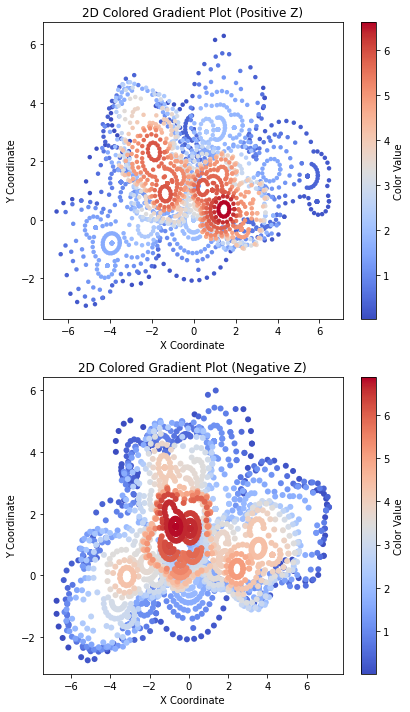

In [27]:
from Jishe import Jishe,getGridDesc

default_radius = 15.0
# CPA_key_atom_num=[3, 2, 1]
# tmp_sdf_file = "TS-cat221-R-5-xyz.sdf"
# tmp_sdf_file = "TS-S-Phv1-RR-tb-11-nos2222.sdf"
# tmp_sdf_file = "JOSIPHOS-1.sdf"
tmp_sdf_file = "./ttt/JOSIPHOS-1.sdf"
print(tmp_sdf_file)
projected_points = Jishe(tmp_sdf_file, key_atom_num=CPA_key_atom_num, sphere_radius=default_radius)[0]

# ????

# 可视化经过极射赤平投影得到的二维散点图
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
# custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])
custom_cmap = "coolwarm"

x_coords = projected_points[:, 0]
y_coords = projected_points[:, 1]
all_min_x = x_coords.min()
all_max_x, all_min_y, all_max_y = x_coords.max(), y_coords.min(), y_coords.max()
colors = projected_points[:, 2]
positive_data = projected_points[colors > 0]
negative_data = projected_points[colors < 0]
abs_colors = np.abs(colors)
# normalized_abs_colors = (abs_colors - abs_colors.min()) / (abs_colors.max() - abs_colors.min())
normalized_abs_colors = abs_colors

# 按照颜色值进行排序，确保c大的点在后面绘制
sorted_indices_positive = np.argsort(normalized_abs_colors[colors > 0])  # 正值部分排序
sorted_indices_negative = np.argsort(normalized_abs_colors[colors < 0])  # 负值部分排序

positive_data = positive_data[sorted_indices_positive]
negative_data = negative_data[sorted_indices_negative]

normalized_abs_colors_positive = normalized_abs_colors[colors > 0][sorted_indices_positive]
normalized_abs_colors_negative = normalized_abs_colors[colors < 0][sorted_indices_negative]


# 创建一个绘图对象
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# 绘制正值部分的颜色填充区域
color_fill = np.zeros((2, 2))
# img_positive = axes[0].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
#                               origin='lower', cmap=custom_cmap)
# 绘制正值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_positive = axes[0].scatter(positive_data[:, 0], positive_data[:, 1], c=normalized_abs_colors_positive,
                                   cmap=custom_cmap, edgecolors='none', s=20)

# 添加颜色栏
color_bar_0 = fig.colorbar(scatter_positive, ax=axes[0])
color_bar_0.set_label('Color Value')

# 添加标题和坐标轴标签
axes[0].set_title('2D Colored Gradient Plot (Positive Z)')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# 绘制负值部分的颜色填充区域
# 为了让y轴方向向下
# img_negative = axes[1].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
#                               origin='lower', cmap=custom_cmap)
# 绘制负值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_negative = axes[1].scatter(negative_data[:, 0], negative_data[:, 1], c=normalized_abs_colors_negative,
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_1 = fig.colorbar(scatter_negative, ax=axes[1])
color_bar_1.set_label('Color Value')

# 添加标题和坐标轴标签
axes[1].set_title('2D Colored Gradient Plot (Negative Z)')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

# 调整子图布局，使得标题和标签不会重叠
plt.tight_layout()
# plt.savefig('GradientPlot.png', dpi=900)
# plt.gca().set_aspect('equal')
# 显示图形
plt.show()

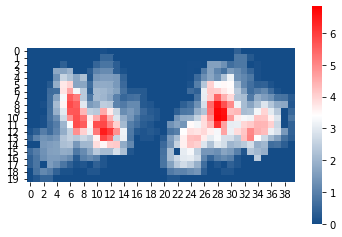

In [28]:
# getGridDesc(projected_points, x_min=-8, x_max=8, y_min=-8, y_max=8, num_bins=50, normalize=True)

# 可视化对二维散点集合进行网格划分的矩阵也就是极射赤平投影描述符
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import seaborn as sns

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])
# custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(1, '#144C87'), (0.5, 'white'), (0, 'red')])

# 
# projected_points = projected_points_list[0]

# 进行网格划分
cat_matric = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)

# print(cat_matric.shape)

# sns.heatmap(cat_matric,cbar=True,cmap='RdBu')
sns.heatmap(cat_matric,cbar=True,cmap=custom_cmap)
plt.gca().set_aspect('equal')
# Set a higher resolution (e.g., 300 dots per inch)
# plt.savefig('./ttt/JOSIPHOS-1.png', dpi=300, bbox_inches='tight')

plt.show()

TS-cat221-R-5-xyz.sdf


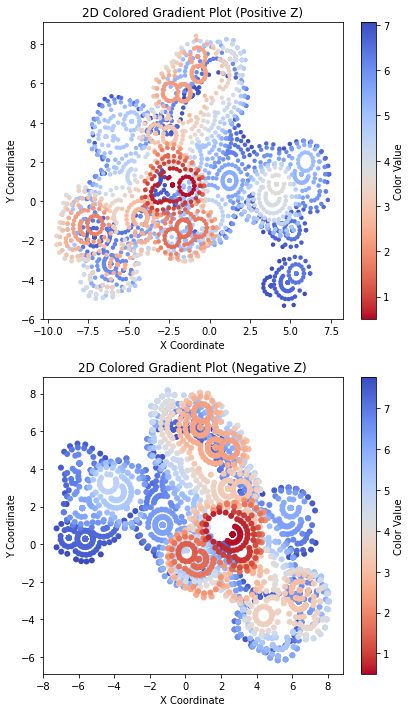

In [29]:
from Jishe import Jishe,getGridDesc,distance_proj

default_radius = 15.0
# CPA_key_atom_num=[3, 2, 1]
tmp_sdf_file = "TS-cat221-R-5-xyz.sdf"
print(tmp_sdf_file)
positive_data, negative_data, projected_points = distance_proj(tmp_sdf_file, key_atom_num=CPA_key_atom_num, sphere_radius=default_radius)

# ????

# 可视化经过极射赤平投影得到的二维散点图
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
# custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])
custom_cmap = "coolwarm_r"

x_coords = projected_points[:, 0]
y_coords = projected_points[:, 1]
all_min_x = x_coords.min()
all_max_x, all_min_y, all_max_y = x_coords.max(), y_coords.min(), y_coords.max()
# colors = projected_points[:, 2]
# positive_data = projected_points[colors > 0]
# negative_data = projected_points[colors < 0]
# abs_colors = np.abs(colors)
# normalized_abs_colors = (abs_colors - abs_colors.min()) / (abs_colors.max() - abs_colors.min())
# normalized_abs_colors = abs_colors

# 按照颜色值进行排序，确保c大的点在后面绘制
sorted_indices_positive = np.argsort(positive_data[:,2])[::-1]  # 正值部分排序
sorted_indices_negative = np.argsort(negative_data[:,2])[::-1]  # 负值部分排序

positive_data = positive_data[sorted_indices_positive]
negative_data = negative_data[sorted_indices_negative]

normalized_abs_colors_positive = positive_data[:,2]
normalized_abs_colors_negative = negative_data[:,2]


# 创建一个绘图对象
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# 绘制正值部分的颜色填充区域
color_fill = np.zeros((2, 2))
# img_positive = axes[0].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
#                               origin='lower', cmap=custom_cmap)
# 绘制正值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_positive = axes[0].scatter(positive_data[:, 0], positive_data[:, 1], c=normalized_abs_colors_positive,
                                   cmap=custom_cmap, edgecolors='none', s=20)

# 添加颜色栏
color_bar_0 = fig.colorbar(scatter_positive, ax=axes[0])
color_bar_0.set_label('Color Value')

# 添加标题和坐标轴标签
axes[0].set_title('2D Colored Gradient Plot (Positive Z)')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# 绘制负值部分的颜色填充区域
# 为了让y轴方向向下
# img_negative = axes[1].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
#                               origin='lower', cmap=custom_cmap)
# 绘制负值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_negative = axes[1].scatter(negative_data[:, 0], negative_data[:, 1], c=normalized_abs_colors_negative,
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_1 = fig.colorbar(scatter_negative, ax=axes[1])
color_bar_1.set_label('Color Value')

# 添加标题和坐标轴标签
axes[1].set_title('2D Colored Gradient Plot (Negative Z)')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

# 调整子图布局，使得标题和标签不会重叠
plt.tight_layout()
# plt.savefig('GradientPlot.png', dpi=900)
# 显示图形
plt.show()

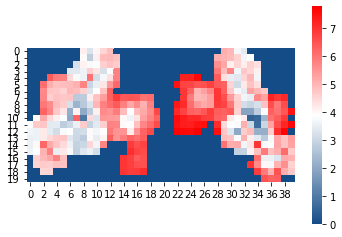

In [24]:
from Jishe import *
# getGridDesc(projected_points, x_min=-8, x_max=8, y_min=-8, y_max=8, num_bins=50, normalize=True)

# 可视化对二维散点集合进行网格划分的矩阵也就是极射赤平投影描述符
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import seaborn as sns

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])
# custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(1, '#144C87'), (0.5, 'white'), (0, 'red')])

# 
# projected_points = projected_points_list[0]

# 进行网格划分
cat_matric = distance_getGridDesc(positive_data, negative_data, projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)

# print(cat_matric.shape)

# sns.heatmap(cat_matric,cbar=True,cmap='RdBu')
sns.heatmap(cat_matric,cbar=True,cmap=custom_cmap)

# Set a higher resolution (e.g., 300 dots per inch)
# plt.savefig('cat_matric.png', dpi=900, bbox_inches='tight')
plt.gca().set_aspect('equal')
plt.show()

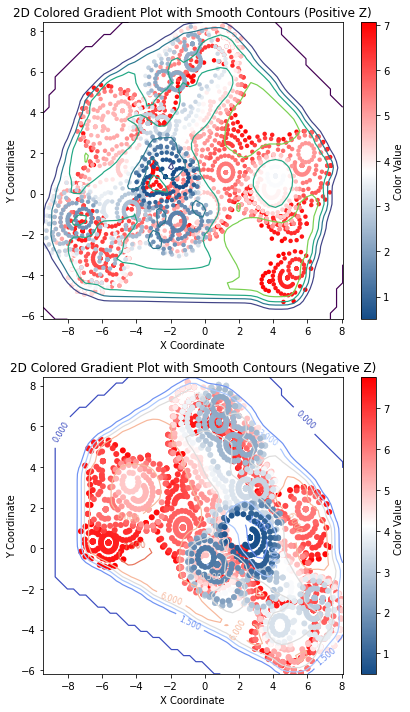

In [25]:
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
import numpy as np

# 创建较低分辨率的网格
grid_x, grid_y = np.meshgrid(
    np.linspace(all_min_x, all_max_x, 50),  # 减少分辨率
    np.linspace(all_min_y, all_max_y, 50)
)

# 插值生成网格数据
grid_z_positive = griddata(
    points=positive_data[:, :2],
    values=normalized_abs_colors_positive,
    xi=(grid_x, grid_y),
    method='linear',  # 使用线性插值，更简单
    fill_value=0
)

grid_z_negative = griddata(
    points=negative_data[:, :2],
    values=normalized_abs_colors_negative,
    xi=(grid_x, grid_y),
    method='linear',
    fill_value=0
)

# 使用高斯滤波平滑数据
grid_z_positive = gaussian_filter(grid_z_positive, sigma=1)
grid_z_negative = gaussian_filter(grid_z_negative, sigma=1)

# 绘图
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# 绘制正值部分散点图
scatter_positive = axes[0].scatter(
    positive_data[:, 0], positive_data[:, 1],
    c=normalized_abs_colors_positive, cmap=custom_cmap, edgecolors='none', s=20
)

# 添加较平滑的等高线
contour_positive = axes[0].contour(
    grid_x, grid_y, grid_z_positive, levels=6, linewidths=1.2  # 减少等高线数量
)
# axes[0].clabel(contour_positive, inline=True, fontsize=8)

# 添加颜色栏
color_bar_0 = fig.colorbar(scatter_positive, ax=axes[0])
color_bar_0.set_label('Color Value')

# 添加标题和坐标轴标签
axes[0].set_title('2D Colored Gradient Plot with Smooth Contours (Positive Z)')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# 绘制负值部分散点图
scatter_negative = axes[1].scatter(
    negative_data[:, 0], negative_data[:, 1],
    c=normalized_abs_colors_negative, cmap=custom_cmap, edgecolors='none'
)

# 添加较平滑的等高线
contour_negative = axes[1].contour(
    grid_x, grid_y, grid_z_negative, levels=6, cmap="coolwarm", linewidths=1.2
)
axes[1].clabel(contour_negative, inline=True, fontsize=8)

# 添加颜色栏
color_bar_1 = fig.colorbar(scatter_negative, ax=axes[1])
color_bar_1.set_label('Color Value')

# 添加标题和坐标轴标签
axes[1].set_title('2D Colored Gradient Plot with Smooth Contours (Negative Z)')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

# 调整子图布局
plt.tight_layout()
plt.show()


## 4. CPA的描述符提取

In [30]:
cpa_sdf_files[0]

'./CPA/cat_9_conf_11.sdf'

In [31]:
# 获取最大半径
cpa_sdf_files.sort(key=lambda x:eval(x.split('/')[-1].split('_')[1]))
all_radius = []
for tmp_sdf_file in cpa_sdf_files:
    spms = SPMS(tmp_sdf_file,desc_n=40,desc_m=40)
    spms._Standarlize_Geomertry()
    tmp_sphere_radius = spms.sphere_radius
    all_radius.append(tmp_sphere_radius)
all_radius = np.array(all_radius)
default_radius = all_radius.max()

RDKit WARNING: [21:49:11] atom 1 has specified valence (1) smaller than the drawn valence 2.


In [32]:
default_radius

15.0

In [33]:
len(cpa_sdf_files)

860

In [34]:
# 文件列表按照名字进行排序
cpa_sdf_files.sort(key=lambda x:eval(x.split('/')[-1].split('_')[1]))
projected_points_list = []

# 对CPA底物的每个分子进行极射赤平投影得到二维点集列表
for tmp_sdf_file in cpa_sdf_files:
    print(tmp_sdf_file)
    projected_points = Jishe(tmp_sdf_file, key_atom_num=CPA_key_atom_num, sphere_radius=default_radius)[0]
    projected_points_list.append(projected_points)
    
# 保存二维点集列表
cat_projected_points = np.array(projected_points_list)
if not os.path.exists('./Jishe_new_81_1'):
    os.mkdir('./Jishe_new_81_1')
# np.save('./Jishe_new_81_1/cat_projected_points.npy',cat_projected_points)

./CPA/cat_0_conf_17.sdf
./CPA/cat_0_conf_20.sdf
./CPA/cat_0_conf_18.sdf
./CPA/cat_0_conf_13.sdf
./CPA/cat_0_conf_6.sdf
./CPA/cat_0_conf_29.sdf
./CPA/cat_0_conf_12.sdf
./CPA/cat_0_conf_27.sdf
./CPA/cat_0_conf_25.sdf
./CPA/cat_0_conf_23.sdf
./CPA/cat_0_conf_0.sdf
./CPA/cat_0_conf_36.sdf
./CPA/cat_0_conf_26.sdf
./CPA/cat_0_conf_5.sdf
./CPA/cat_0_conf_31.sdf
./CPA/cat_0_conf_21.sdf
./CPA/cat_0_conf_24.sdf
./CPA/cat_0_conf_37.sdf
./CPA/cat_0_conf_33.sdf
./CPA/cat_0_conf_3.sdf
./CPA/cat_1_conf_36.sdf
./CPA/cat_1_conf_37.sdf
./CPA/cat_1_conf_29.sdf
./CPA/cat_1_conf_15.sdf
./CPA/cat_1_conf_47.sdf
./CPA/cat_1_conf_7.sdf
./CPA/cat_1_conf_17.sdf
./CPA/cat_1_conf_35.sdf
./CPA/cat_1_conf_30.sdf
./CPA/cat_1_conf_12.sdf
./CPA/cat_1_conf_11.sdf
./CPA/cat_1_conf_5.sdf
./CPA/cat_1_conf_25.sdf
./CPA/cat_1_conf_18.sdf
./CPA/cat_1_conf_41.sdf
./CPA/cat_1_conf_38.sdf
./CPA/cat_1_conf_8.sdf
./CPA/cat_1_conf_32.sdf
./CPA/cat_1_conf_31.sdf
./CPA/cat_1_conf_43.sdf
./CPA/cat_2_conf_22.sdf
./CPA/cat_2_conf_3.sdf


RDKit WARNING: [21:50:34] atom 1 has specified valence (1) smaller than the drawn valence 2.


./CPA/cat_7_conf_25.sdf
./CPA/cat_7_conf_39.sdf
./CPA/cat_7_conf_30.sdf
./CPA/cat_7_conf_41.sdf
./CPA/cat_7_conf_6.sdf
./CPA/cat_7_conf_9.sdf
./CPA/cat_8_conf_44.sdf
./CPA/cat_8_conf_25.sdf
./CPA/cat_8_conf_16.sdf
./CPA/cat_8_conf_61.sdf
./CPA/cat_8_conf_51.sdf
./CPA/cat_8_conf_27.sdf
./CPA/cat_8_conf_56.sdf
./CPA/cat_8_conf_48.sdf
./CPA/cat_8_conf_5.sdf
./CPA/cat_8_conf_52.sdf
./CPA/cat_8_conf_55.sdf
./CPA/cat_8_conf_9.sdf
./CPA/cat_8_conf_43.sdf
./CPA/cat_8_conf_1.sdf
./CPA/cat_8_conf_37.sdf
./CPA/cat_8_conf_26.sdf
./CPA/cat_8_conf_32.sdf
./CPA/cat_8_conf_29.sdf
./CPA/cat_8_conf_41.sdf
./CPA/cat_8_conf_13.sdf
./CPA/cat_9_conf_11.sdf
./CPA/cat_9_conf_29.sdf
./CPA/cat_9_conf_31.sdf
./CPA/cat_9_conf_25.sdf
./CPA/cat_9_conf_7.sdf
./CPA/cat_9_conf_27.sdf
./CPA/cat_9_conf_16.sdf
./CPA/cat_9_conf_24.sdf
./CPA/cat_9_conf_5.sdf
./CPA/cat_9_conf_28.sdf
./CPA/cat_9_conf_33.sdf
./CPA/cat_9_conf_1.sdf
./CPA/cat_9_conf_0.sdf
./CPA/cat_9_conf_26.sdf
./CPA/cat_9_conf_8.sdf
./CPA/cat_9_conf_15.sdf
./

./CPA/cat_24_conf_21.sdf
./CPA/cat_24_conf_9.sdf
./CPA/cat_24_conf_4.sdf
./CPA/cat_24_conf_2.sdf
./CPA/cat_24_conf_13.sdf
./CPA/cat_24_conf_23.sdf
./CPA/cat_24_conf_3.sdf
./CPA/cat_24_conf_1.sdf
./CPA/cat_24_conf_32.sdf
./CPA/cat_24_conf_24.sdf
./CPA/cat_24_conf_6.sdf
./CPA/cat_24_conf_33.sdf
./CPA/cat_24_conf_5.sdf
./CPA/cat_25_conf_3.sdf
./CPA/cat_25_conf_1.sdf
./CPA/cat_25_conf_20.sdf
./CPA/cat_25_conf_28.sdf
./CPA/cat_25_conf_7.sdf
./CPA/cat_25_conf_11.sdf
./CPA/cat_25_conf_21.sdf
./CPA/cat_25_conf_27.sdf
./CPA/cat_25_conf_4.sdf
./CPA/cat_25_conf_29.sdf
./CPA/cat_25_conf_12.sdf
./CPA/cat_25_conf_19.sdf
./CPA/cat_25_conf_0.sdf
./CPA/cat_25_conf_16.sdf
./CPA/cat_25_conf_15.sdf
./CPA/cat_25_conf_5.sdf
./CPA/cat_25_conf_31.sdf
./CPA/cat_25_conf_10.sdf
./CPA/cat_25_conf_23.sdf
./CPA/cat_25_conf_24.sdf
./CPA/cat_26_conf_6.sdf
./CPA/cat_26_conf_27.sdf
./CPA/cat_26_conf_18.sdf
./CPA/cat_26_conf_17.sdf
./CPA/cat_26_conf_12.sdf
./CPA/cat_26_conf_3.sdf
./CPA/cat_26_conf_19.sdf
./CPA/cat_26_co

./CPA/cat_40_conf_22.sdf
./CPA/cat_41_conf_38.sdf
./CPA/cat_41_conf_23.sdf
./CPA/cat_41_conf_28.sdf
./CPA/cat_41_conf_30.sdf
./CPA/cat_41_conf_17.sdf
./CPA/cat_41_conf_13.sdf
./CPA/cat_41_conf_31.sdf
./CPA/cat_41_conf_10.sdf
./CPA/cat_41_conf_33.sdf
./CPA/cat_41_conf_14.sdf
./CPA/cat_41_conf_19.sdf
./CPA/cat_41_conf_2.sdf
./CPA/cat_41_conf_18.sdf
./CPA/cat_41_conf_21.sdf
./CPA/cat_41_conf_6.sdf
./CPA/cat_41_conf_36.sdf
./CPA/cat_41_conf_22.sdf
./CPA/cat_41_conf_9.sdf
./CPA/cat_41_conf_39.sdf
./CPA/cat_41_conf_40.sdf
./CPA/cat_42_conf_5.sdf
./CPA/cat_42_conf_14.sdf
./CPA/cat_42_conf_9.sdf
./CPA/cat_42_conf_34.sdf
./CPA/cat_42_conf_38.sdf
./CPA/cat_42_conf_39.sdf
./CPA/cat_42_conf_29.sdf
./CPA/cat_42_conf_10.sdf
./CPA/cat_42_conf_17.sdf
./CPA/cat_42_conf_15.sdf
./CPA/cat_42_conf_25.sdf
./CPA/cat_42_conf_19.sdf
./CPA/cat_42_conf_20.sdf
./CPA/cat_42_conf_40.sdf
./CPA/cat_42_conf_8.sdf
./CPA/cat_42_conf_33.sdf
./CPA/cat_42_conf_21.sdf
./CPA/cat_42_conf_37.sdf
./CPA/cat_42_conf_3.sdf
./CPA/c

In [35]:
projected_points_list = np.load('./Jishe_new_81_1/cat_projected_points.npy', allow_pickle=True)

In [36]:
projected_points_list[1].shape

(4895, 4)

In [37]:
# 获取所有分子极射赤平投影得到的二维点集x方向和y方向的最大范围
all_min_x, all_max_x, all_min_y, all_max_y = get_xy_range(projected_points_list)
print(all_min_x, all_max_x, all_min_y, all_max_y)

-13.638666414056901 13.886141946331158 -9.15332974353142 9.506553192724846


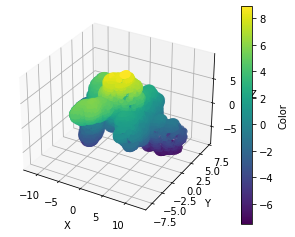

In [38]:
# %matplotlib notebook
# 可视化采样的范德华表面
_, samples = Jishe(cpa_sdf_files[22], key_atom_num=CPA_key_atom_num)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# data = cat_poc['O=P1(O)OC2=C(C3=CC(C)=C(OC(C)C)C(C)=C3)C=C4C(C=CC=C4)=C2C5=C(O1)C(C6=CC(C)=C(OC(C)C)C(C)=C6)=CC7=C5C=CC=C7']
# data = extract_data(dirs[1])
data = samples
# 提取坐标和颜色信息
x = [row[0] for row in data]
y = [row[1] for row in data]
z = [row[2] for row in data]
colors = [row[2] for row in data]

# 绘制三维散点图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=colors, cmap='viridis')

# 添加颜色条
cbar = fig.colorbar(scatter)
cbar.set_label('Color')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图形
plt.show()

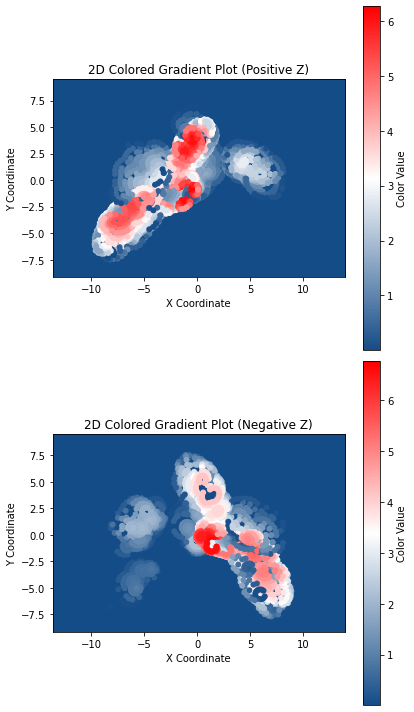

In [39]:
# ????

# 可视化经过极射赤平投影得到的二维散点图
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

projected_points = projected_points_list[22]

x_coords = projected_points[:, 0]
y_coords = projected_points[:, 1]
colors = projected_points[:, 2]
positive_data = projected_points[colors > 0]
negative_data = projected_points[colors < 0]
abs_colors = np.abs(colors)
# normalized_abs_colors = (abs_colors - abs_colors.min()) / (abs_colors.max() - abs_colors.min())
normalized_abs_colors = abs_colors

# 创建一个绘图对象
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# 绘制正值部分的颜色填充区域
color_fill = np.zeros((2, 2))
img_positive = axes[0].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制正值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_positive = axes[0].scatter(positive_data[:, 0], positive_data[:, 1], c=normalized_abs_colors[colors > 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_0 = fig.colorbar(scatter_positive, ax=axes[0])
color_bar_0.set_label('Color Value')

# 添加标题和坐标轴标签
axes[0].set_title('2D Colored Gradient Plot (Positive Z)')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# 绘制负值部分的颜色填充区域
# 为了让y轴方向向下
img_negative = axes[1].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制负值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_negative = axes[1].scatter(negative_data[:, 0], negative_data[:, 1], c=normalized_abs_colors[colors < 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_1 = fig.colorbar(scatter_negative, ax=axes[1])
color_bar_1.set_label('Color Value')

# 添加标题和坐标轴标签
axes[1].set_title('2D Colored Gradient Plot (Negative Z)')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

# 调整子图布局，使得标题和标签不会重叠
plt.tight_layout()
# plt.savefig('GradientPlot.png', dpi=900)
# 显示图形
plt.show()

In [40]:
row_cat, col_cat = get_origin_grid_position(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [41]:
row_cat, col_cat

(11, 9)

In [42]:
x_min_mid_cat, x_step_cat, y_min_mid_cat, y_step_cat = get_xy_step(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [43]:
x_min_mid_cat, x_step_cat, y_min_mid_cat, y_step_cat

(-12.9505462050472, 1.3762404180194028, -8.686832670125014, 0.9329941468128133)

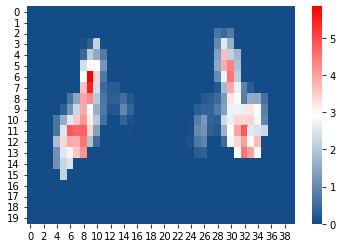

In [44]:
# 可视化对二维散点集合进行网格划分的矩阵也就是极射赤平投影描述符
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import seaborn as sns

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])
# custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(1, '#144C87'), (0.5, 'white'), (0, 'red')])

# 
projected_points = projected_points_list[0]

# 进行网格划分
cat_matric = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)

# print(cat_matric.shape)

# sns.heatmap(cat_matric,cbar=True,cmap='RdBu')
sns.heatmap(cat_matric,cbar=True,cmap=custom_cmap)

# Set a higher resolution (e.g., 300 dots per inch)
# plt.savefig('cat_matric.png', dpi=900, bbox_inches='tight')

plt.show()

In [45]:
### 对所有分子的二维散点分别进行网格划分得到二维矩阵
all_desc = []
for projected_points in projected_points_list:
    # 网格划分
    desc = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)
    all_desc.append(desc)
cat_matric_list = all_desc
cat_matric_list_2 = all_desc
all_desc = np.array(all_desc)

In [46]:
all_desc.shape

(860, 20, 40)

In [47]:
cat_desc_dict = {}
# 创建一个字典用于存储smiles码和对应的所有构象的极射赤平二维矩阵
cat_matric_list = []
for item in cat_smiles_set:
    cat_desc_dict[item] = []
for i in range(len(all_desc)):
    tmp_sdf_file = cpa_sdf_files[i]
    # 读取sdf文件对应的smiles码
    with open(tmp_sdf_file,'r') as fr:
        tmp_smiles = fr.readlines()[0].strip()
    # 对应smiles码的所有的构象矩阵都存储在一个对应的列表中
    cat_desc_dict[tmp_smiles].append(all_desc[i])
    
# 创建一个字典用于存储smiles码和对应的所有构象平均的极射赤平二维矩阵
new_cat_desc_dict = {}
for tmp_key in cat_smiles_set:
    # 对应的所有构象的矩阵平均
    new_cat_desc_dict[tmp_key] = np.average(np.array(cat_desc_dict[tmp_key]),axis=0)
    cat_matric_list.append(np.average(np.array(cat_desc_dict[tmp_key]),axis=0))

In [48]:
len(cat_matric_list)

43

## 5. Imine的描述符提取 

In [49]:
imine_sdf_files.sort(key=lambda x:eval(x.split('/')[-1].split('_')[1]))
all_radius = []
for tmp_sdf_file in imine_sdf_files:
    spms = SPMS(tmp_sdf_file,desc_n=40,desc_m=40)
    spms._Standarlize_Geomertry()
    tmp_sphere_radius = spms.sphere_radius
    all_radius.append(tmp_sphere_radius)
all_radius = np.array(all_radius)
default_radius = all_radius.max()

In [50]:
default_radius

9.0

In [51]:
imine_sdf_files.sort(key=lambda x:eval(x.split('/')[-1].split('_')[1]))
projected_points_list = []
for tmp_sdf_file in imine_sdf_files:
    print(tmp_sdf_file)
    projected_points = Jishe(tmp_sdf_file, key_atom_num=imine_key_atom_num, sphere_radius=default_radius)[0]
    projected_points_list.append(projected_points)

imine_projected_points = np.array(projected_points_list)
if not os.path.exists('./Jishe_new_81_1'):
    os.mkdir('./Jishe_new_81_1')
# np.save('./Jishe_new_81_1/imine_projected_points.npy',imine_projected_points)

./imine/imine_0_conf_8.sdf
./imine/imine_0_conf_9.sdf
./imine/imine_0_conf_6.sdf
./imine/imine_0_conf_7.sdf
./imine/imine_0_conf_14.sdf
./imine/imine_0_conf_18.sdf
./imine/imine_0_conf_0.sdf
./imine/imine_0_conf_15.sdf
./imine/imine_0_conf_5.sdf
./imine/imine_0_conf_11.sdf
./imine/imine_0_conf_4.sdf
./imine/imine_0_conf_2.sdf
./imine/imine_0_conf_17.sdf
./imine/imine_0_conf_13.sdf
./imine/imine_0_conf_1.sdf
./imine/imine_0_conf_3.sdf
./imine/imine_0_conf_16.sdf
./imine/imine_0_conf_12.sdf
./imine/imine_0_conf_10.sdf
./imine/imine_0_conf_19.sdf
./imine/imine_1_conf_1.sdf
./imine/imine_1_conf_4.sdf
./imine/imine_1_conf_7.sdf
./imine/imine_1_conf_8.sdf
./imine/imine_1_conf_19.sdf
./imine/imine_1_conf_10.sdf
./imine/imine_1_conf_2.sdf
./imine/imine_1_conf_12.sdf
./imine/imine_1_conf_14.sdf
./imine/imine_1_conf_17.sdf
./imine/imine_1_conf_6.sdf
./imine/imine_1_conf_3.sdf
./imine/imine_1_conf_16.sdf
./imine/imine_1_conf_5.sdf
./imine/imine_1_conf_11.sdf
./imine/imine_1_conf_15.sdf
./imine/im

In [52]:
projected_points_list = np.load('./Jishe_new_81_1/imine_projected_points.npy', allow_pickle=True)

In [53]:
all_min_x, all_max_x, all_min_y, all_max_y = get_xy_range(projected_points_list)
print(all_min_x, all_max_x, all_min_y, all_max_y)

-1.6865949922346124 1.6999999999999997 -7.739413542957949 6.254709535708637


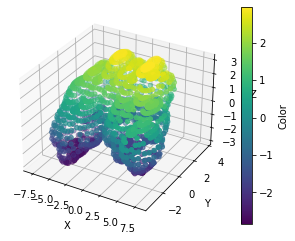

In [54]:
# 可视化采样的范德华表面
projected_points, samples = Jishe(imine_sdf_files[44], key_atom_num=imine_key_atom_num)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# data = cat_poc['O=P1(O)OC2=C(C3=CC(C)=C(OC(C)C)C(C)=C3)C=C4C(C=CC=C4)=C2C5=C(O1)C(C6=CC(C)=C(OC(C)C)C(C)=C6)=CC7=C5C=CC=C7']
# data = extract_data(dirs[1])
data = samples
# 提取坐标和颜色信息
x = [row[0] for row in data]
y = [row[1] for row in data]
z = [row[2] for row in data]
colors = [row[2] for row in data]

# 绘制三维散点图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=colors, cmap='viridis')

# 添加颜色条
cbar = fig.colorbar(scatter)
cbar.set_label('Color')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图形
plt.show()

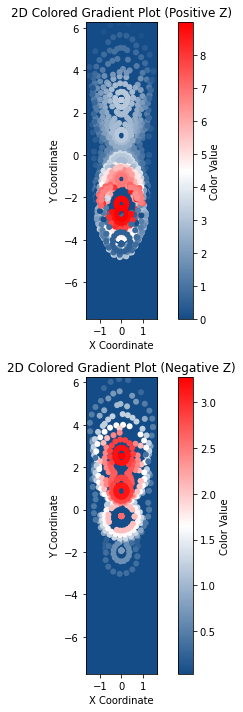

In [55]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

projected_points = projected_points_list[44]

x_coords = projected_points[:, 0]
y_coords = projected_points[:, 1]
colors = projected_points[:, 2]
positive_data = projected_points[colors > 0]
negative_data = projected_points[colors < 0]
abs_colors = np.abs(colors)
# normalized_abs_colors = (abs_colors - abs_colors.min()) / (abs_colors.max() - abs_colors.min())
normalized_abs_colors = abs_colors

# 创建一个绘图对象
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# 绘制正值部分的颜色填充区域
color_fill = np.zeros((2, 2))
img_positive = axes[0].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制正值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_positive = axes[0].scatter(positive_data[:, 0], positive_data[:, 1], c=normalized_abs_colors[colors > 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_0 = fig.colorbar(scatter_positive, ax=axes[0])
color_bar_0.set_label('Color Value')

# 添加标题和坐标轴标签
axes[0].set_title('2D Colored Gradient Plot (Positive Z)')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# 绘制负值部分的颜色填充区域
img_negative = axes[1].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制负值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_negative = axes[1].scatter(negative_data[:, 0], negative_data[:, 1], c=normalized_abs_colors[colors < 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_1 = fig.colorbar(scatter_negative, ax=axes[1])
color_bar_1.set_label('Color Value')

# 添加标题和坐标轴标签
axes[1].set_title('2D Colored Gradient Plot (Negative Z)')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

# 调整子图布局，使得标题和标签不会重叠
plt.tight_layout()
# plt.savefig(output_filename_zh)
# 显示图形
plt.show()

<AxesSubplot:>

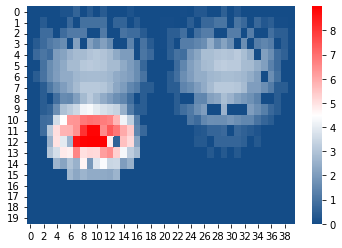

In [56]:
# 可视化对二维散点集合进行网格划分的矩阵也就是极射赤平投影描述符
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import seaborn as sns

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])
# custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(1, '#144C87'), (0.5, 'white'), (0, 'red')])

projected_points = projected_points_list[44]

imine_matric = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)

# sns.heatmap(imine_matric,cbar=False,cmap='RdBu')
sns.heatmap(imine_matric,cbar=True,cmap=custom_cmap)

In [57]:
row_imine, col_imine = get_origin_grid_position(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [58]:
x_min_mid_imine, x_step_imine, y_min_mid_imine, y_step_imine = get_xy_step(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [59]:
### Execute this cell will take few seconds or few minutes
all_desc = []
for projected_points in projected_points_list:
    desc = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)
    all_desc.append(desc)
imine_matric_list = all_desc
imine_matric_list_2 = all_desc
all_desc = np.array(all_desc)

In [60]:
imine_desc_dict = {}
imine_matric_list = []
for item in imine_smiles_set:
    imine_desc_dict[item] = []
for i in range(len(all_desc)):
    tmp_sdf_file = imine_sdf_files[i]
    with open(tmp_sdf_file,'r') as fr:
        tmp_smiles = fr.readlines()[0].strip()
    imine_desc_dict[tmp_smiles].append(all_desc[i])
new_imine_desc_dict = {}
for tmp_key in imine_smiles_set:
    new_imine_desc_dict[tmp_key] = np.average(np.array(imine_desc_dict[tmp_key]),axis=0)
    imine_matric_list.append(np.average(np.array(imine_desc_dict[tmp_key]),axis=0))

## 7. Thiol的描述符提取 

In [61]:
thiol_sdf_files.sort(key=lambda x:eval(x.split('/')[-1].split('_')[1]))
all_radius = []
for tmp_sdf_file in thiol_sdf_files:
    spms = SPMS(tmp_sdf_file,desc_n=40,desc_m=40)
    spms._Standarlize_Geomertry()
    tmp_sphere_radius = spms.sphere_radius
    all_radius.append(tmp_sphere_radius)
all_radius = np.array(all_radius)
default_radius = all_radius.max()

In [62]:
default_radius

6.0

In [63]:
thiol_sdf_files.sort(key=lambda x:eval(x.split('/')[-1].split('_')[1]))
projected_points_list = []
for tmp_sdf_file in thiol_sdf_files:
    print(tmp_sdf_file)
    projected_points = Jishe(tmp_sdf_file, key_atom_num=thiol_key_atom_num, sphere_radius=default_radius)[0]
    projected_points_list.append(projected_points)

thiol_projected_points = np.array(projected_points_list)
if not os.path.exists('./Jishe_new_81_1'):
    os.mkdir('./Jishe_new_81_1')
# np.save('./Jishe_new_81_1/thiol_projected_points.npy',thiol_projected_points)

./thiol/thiol_0_conf_3.sdf
./thiol/thiol_0_conf_7.sdf
./thiol/thiol_0_conf_10.sdf
./thiol/thiol_0_conf_4.sdf
./thiol/thiol_0_conf_15.sdf
./thiol/thiol_0_conf_16.sdf
./thiol/thiol_0_conf_6.sdf
./thiol/thiol_0_conf_18.sdf
./thiol/thiol_0_conf_14.sdf
./thiol/thiol_0_conf_12.sdf
./thiol/thiol_0_conf_0.sdf
./thiol/thiol_0_conf_17.sdf
./thiol/thiol_0_conf_5.sdf
./thiol/thiol_0_conf_8.sdf
./thiol/thiol_0_conf_13.sdf
./thiol/thiol_0_conf_11.sdf
./thiol/thiol_0_conf_2.sdf
./thiol/thiol_0_conf_19.sdf
./thiol/thiol_0_conf_1.sdf
./thiol/thiol_0_conf_9.sdf
./thiol/thiol_1_conf_14.sdf
./thiol/thiol_1_conf_19.sdf
./thiol/thiol_1_conf_13.sdf
./thiol/thiol_1_conf_18.sdf
./thiol/thiol_1_conf_1.sdf
./thiol/thiol_1_conf_16.sdf
./thiol/thiol_1_conf_5.sdf
./thiol/thiol_1_conf_7.sdf
./thiol/thiol_1_conf_2.sdf
./thiol/thiol_1_conf_9.sdf
./thiol/thiol_1_conf_15.sdf
./thiol/thiol_1_conf_17.sdf
./thiol/thiol_1_conf_10.sdf
./thiol/thiol_1_conf_8.sdf
./thiol/thiol_1_conf_6.sdf
./thiol/thiol_1_conf_3.sdf
./thiol/th

In [64]:
projected_points_list = np.load('./Jishe_new_81_1/thiol_projected_points.npy', allow_pickle=True)

In [65]:
all_min_x, all_max_x, all_min_y, all_max_y = get_xy_range(projected_points_list)
print(all_min_x, all_max_x, all_min_y, all_max_y)

-4.106905312245296 4.127375979223134 -3.145779815824021 4.1740441296485615


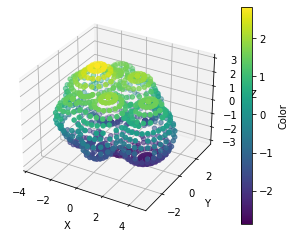

In [66]:
# 可视化采样的范德华表面
projected_points, samples = Jishe(thiol_sdf_files[44], key_atom_num=thiol_key_atom_num)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# data = cat_poc['O=P1(O)OC2=C(C3=CC(C)=C(OC(C)C)C(C)=C3)C=C4C(C=CC=C4)=C2C5=C(O1)C(C6=CC(C)=C(OC(C)C)C(C)=C6)=CC7=C5C=CC=C7']
# data = extract_data(dirs[1])
data = samples
# 提取坐标和颜色信息
x = [row[0] for row in data]
y = [row[1] for row in data]
z = [row[2] for row in data]
colors = [row[2] for row in data]

# 绘制三维散点图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=colors, cmap='viridis')

# 添加颜色条
cbar = fig.colorbar(scatter)
cbar.set_label('Color')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图形
plt.show()

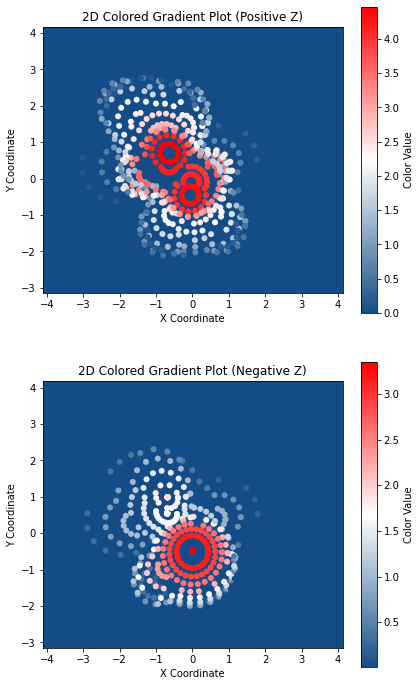

In [67]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])

projected_points = projected_points_list[44]

x_coords = projected_points[:, 0]
y_coords = projected_points[:, 1]
colors = projected_points[:, 2]
positive_data = projected_points[colors > 0]
negative_data = projected_points[colors < 0]
abs_colors = np.abs(colors)
# normalized_abs_colors = (abs_colors - abs_colors.min()) / (abs_colors.max() - abs_colors.min())
normalized_abs_colors = abs_colors

# 创建一个绘图对象
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# 绘制正值部分的颜色填充区域
color_fill = np.zeros((2, 2))
img_positive = axes[0].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制正值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_positive = axes[0].scatter(positive_data[:, 0], positive_data[:, 1], c=normalized_abs_colors[colors > 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_0 = fig.colorbar(scatter_positive, ax=axes[0])
color_bar_0.set_label('Color Value')

# 添加标题和坐标轴标签
axes[0].set_title('2D Colored Gradient Plot (Positive Z)')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# 绘制负值部分的颜色填充区域
img_negative = axes[1].imshow(color_fill, extent=[all_min_x, all_max_x, all_min_y, all_max_y],
                              origin='lower', cmap=custom_cmap)
# 绘制负值部分的散点图，根据颜色值设置颜色，消除点的轮廓
scatter_negative = axes[1].scatter(negative_data[:, 0], negative_data[:, 1], c=normalized_abs_colors[colors < 0],
                                   cmap=custom_cmap, edgecolors='none')

# 添加颜色栏
color_bar_1 = fig.colorbar(scatter_negative, ax=axes[1])
color_bar_1.set_label('Color Value')

# 添加标题和坐标轴标签
axes[1].set_title('2D Colored Gradient Plot (Negative Z)')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

# 调整子图布局，使得标题和标签不会重叠
plt.tight_layout()
# plt.savefig(output_filename_zh)
# 显示图形
plt.show()

<AxesSubplot:>

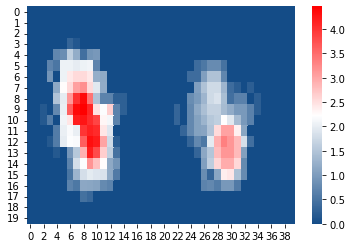

In [68]:
# 可视化对二维散点集合进行网格划分的矩阵也就是极射赤平投影描述符
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import seaborn as sns

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (1, 'red')])
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])
# custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(1, '#144C87'), (0.5, 'white'), (0, 'red')])

projected_points = projected_points_list[44]
thiol_matric = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)

# sns.heatmap(thiol_matric,cbar=False,cmap='RdBu')
sns.heatmap(thiol_matric,cbar=True,cmap=custom_cmap)

In [69]:
row_thiol, col_thiol = get_origin_grid_position(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [70]:
x_min_mid_thiol, x_step_thiol, y_min_mid_thiol, y_step_thiol = get_xy_step(all_min_x, all_max_x, all_min_y, all_max_y, num_bins=20)

In [71]:
### Execute this cell will take few seconds or few minutes
all_desc = []
for projected_points in projected_points_list:
    desc = getGridDesc(projected_points, x_min=all_min_x, x_max=all_max_x, y_min=all_min_y, y_max=all_max_y, num_bins=20, normalize=False)
    all_desc.append(desc)
thiol_matric_list = all_desc
thiol_matric_list_2 = all_desc
all_desc = np.array(all_desc)

In [72]:
thiol_desc_dict = {}
thiol_matric_list = []
for item in thiol_smiles_set:
    thiol_desc_dict[item] = []

for i in range(len(all_desc)):
    
    tmp_sdf_file = thiol_sdf_files[i]
    with open(tmp_sdf_file,'r') as fr:
        tmp_smiles = fr.readlines()[0].strip()
    
    thiol_desc_dict[tmp_smiles].append(all_desc[i])
new_thiol_desc_dict = {}
for tmp_key in thiol_smiles_set:
    new_thiol_desc_dict[tmp_key] = np.average(np.array(thiol_desc_dict[tmp_key]),axis=0)
    thiol_matric_list.append(np.average(np.array(thiol_desc_dict[tmp_key]),axis=0))

## 8. 按照反应顺序依次取出不同底物的描述符

In [73]:
# 按照反应的顺序一次取出对应分子的描述符
react_cat_desc = np.array([new_cat_desc_dict[item] for item in cat_smiles])
react_imine_desc = np.array([new_imine_desc_dict[item] for item in imine_smiles])
react_thiol_desc = np.array([new_thiol_desc_dict[item] for item in thiol_smiles])
# 保存描述符
# if not os.path.exists('./Jishe_new_81_1/20X40_abs'):
#     os.mkdir('./Jishe_new_81_1/20X40_abs')
# np.save('./Jishe_new_81_1/20X40_abs/cat.npy',react_cat_desc)
# np.save('./Jishe_new_81_1/20X40_abs/imine.npy',react_imine_desc)
# np.save('./Jishe_new_81_1/20X40_abs/thiol.npy',react_thiol_desc)

In [74]:
react_cat_desc = np.load('./Jishe_new_81_1/20X40_abs/cat.npy')
react_imine_desc = np.load('./Jishe_new_81_1/20X40_abs/imine.npy')
react_thiol_desc = np.load('./Jishe_new_81_1/20X40_abs/thiol.npy')

In [75]:
react_cat_desc.shape

(1075, 20, 40)

In [76]:
importances_1 = np.load(os.path.join('/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results2D', 'rf_importance.npy'))

In [77]:
importances_1 = importances_1[::-1]

In [78]:
%matplotlib inline

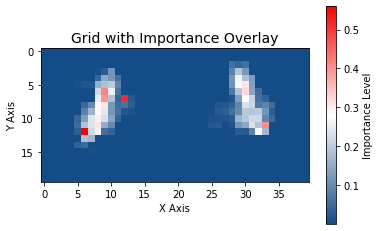

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# 假设重要性数据 importance_matrix
importance_matrix = np.random.rand(20, 40)  # 示例随机重要性矩阵

# 绘制原始热力图
# plt.figure(figsize=(10, 8))
# sns.heatmap(react_cat_desc[0], cbar=True, cmap=custom_cmap)

# # 叠加重要性数据
# plt.imshow(importances_1, cmap='coolwarm', extent=[0, 40, 0, 20], zorder=2)

react_cat_desc = (react_cat_desc - react_cat_desc.min())/(react_cat_desc.max() - react_cat_desc.min())

# 加权叠加
alpha = 0.5  # 原始热力图的权重
beta = 0.5   # 重要性热力图的权重
combined = alpha * react_cat_desc[0] + beta * importances_1[:, :, 0]
combined = np.clip(combined, 0, 1)  # 防止超出范围

# 转换为伪彩色（Jet 色图）
# combined_colored = cv2.applyColorMap((combined * 255).astype(np.uint8), cv2.COLORMAP_JET)

# # 显示结果
# plt.figure(figsize=(8, 8))
# plt.axis('off')
# plt.imshow(cv2.cvtColor(combined_colored, cv2.COLOR_BGR2RGB))
# plt.show()

plt.imshow(combined, cmap=custom_cmap)
# plt.imshow(importances_1, cmap='jet', alpha=0.9)  # 将热力图叠加在原始图像上

# 添加坐标轴和标题
plt.title("Grid with Importance Overlay", fontsize=14)
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.colorbar(label="Importance Level")
plt.show()


## 9. 基于Guided_GradCam的重要性分析

### 9.1 数据的预处理

In [81]:
%matplotlib inline

In [82]:
def min_max(feature_importances):
    min_value = feature_importances.min()
    max_value = feature_importances.max()
    feature_importances = (feature_importances - min_value) / (max_value - min_value)
    return feature_importances

In [83]:
importance_maps = np.load('/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results2D/ensemble_all.npy')
# importance_maps = np.load('/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results2D/vanilla_all.npy')

importance_maps.shape

(1075, 20, 40, 3)

In [84]:
feature_importances = np.average(importance_maps,axis=0)
feature_importances.shape

(20, 40, 3)

In [85]:
feature_importances.min()

0.00034199410969537825

In [86]:
feature_importances.max()

0.9998888773220674

In [87]:
min_value = feature_importances.min()
max_value = feature_importances.max()
feature_importances = (feature_importances - min_value) / (max_value - min_value)

In [88]:
feature_importances[:100]

array([[[1.79251772e-03, 9.27708880e-04, 1.00128919e-03],
        [2.33469298e-03, 1.09624125e-03, 1.29020107e-03],
        [4.59765713e-03, 2.28860427e-03, 4.63142375e-03],
        ...,
        [3.48469967e-03, 3.46829763e-03, 3.00741666e-03],
        [2.58078304e-03, 9.22824577e-04, 3.67850334e-03],
        [1.62568457e-04, 0.00000000e+00, 4.14218189e-04]],

       [[2.28471161e-03, 5.64234978e-04, 1.00641856e-03],
        [2.20111110e-03, 2.57199874e-03, 1.69339485e-03],
        [4.89265287e-03, 3.36890625e-03, 4.06770660e-03],
        ...,
        [4.01482873e-03, 3.57317441e-03, 2.89487243e-03],
        [3.08358220e-03, 2.00740489e-03, 3.10690060e-03],
        [9.28881802e-04, 8.81709263e-05, 4.11202845e-04]],

       [[3.08992079e-03, 3.22615426e-03, 1.67821939e-03],
        [5.36065044e-03, 3.49025871e-03, 2.82962040e-03],
        [1.18097248e-02, 6.18396764e-03, 6.17806877e-03],
        ...,
        [9.00317947e-03, 4.58275567e-03, 4.65426780e-03],
        [6.81711206e-03, 3.78

In [89]:
cat_importance_dict = {}
for item in cat_smiles_set:
    cat_importance_dict[item] = []
for i in range(importance_maps.shape[0]):
    tmp_smiles = cat_smiles[i]
    # 对应smiles码的所有的构象矩阵都存储在一个对应的列表中
    cat_importance_dict[tmp_smiles].append(importance_maps[i, :, :, 0])
    
# 创建一个字典用于存储smiles码和对应的所有构象平均的极射赤平二维矩阵
new_cat_importance_dict = {}
for tmp_key in cat_smiles_set:
    # 对应的所有构象的矩阵平均
    new_cat_importance_dict[tmp_key] = min_max(np.average(np.array(cat_importance_dict[tmp_key]),axis=0))

In [90]:
imine_importance_dict = {}
for item in imine_smiles_set:
    imine_importance_dict[item] = []
for i in range(importance_maps.shape[0]):
    tmp_smiles = imine_smiles[i]
    # 对应smiles码的所有的构象矩阵都存储在一个对应的列表中
    imine_importance_dict[tmp_smiles].append(importance_maps[i, :, :, 1])
    
# 创建一个字典用于存储smiles码和对应的所有构象平均的极射赤平二维矩阵
new_imine_importance_dict = {}
for tmp_key in imine_smiles_set:
    # 对应的所有构象的矩阵平均
    new_imine_importance_dict[tmp_key] = min_max(np.average(np.array(imine_importance_dict[tmp_key]),axis=0))

In [91]:
thiol_importance_dict = {}
for item in thiol_smiles_set:
    thiol_importance_dict[item] = []
for i in range(importance_maps.shape[0]):
    tmp_smiles = thiol_smiles[i]
    # 对应smiles码的所有的构象矩阵都存储在一个对应的列表中
    thiol_importance_dict[tmp_smiles].append(importance_maps[i, :, :, 2])
    
# 创建一个字典用于存储smiles码和对应的所有构象平均的极射赤平二维矩阵
new_thiol_importance_dict = {}
for tmp_key in thiol_smiles_set:
    # 对应的所有构象的矩阵平均
    new_thiol_importance_dict[tmp_key] = min_max(np.average(np.array(thiol_importance_dict[tmp_key]),axis=0))

In [92]:
new_thiol_importance_dict['CCS'].shape

(20, 40)

<AxesSubplot:>

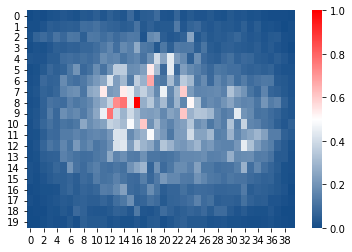

In [93]:
import matplotlib.colors as mcolors
# 自定义颜色映射列表，从蓝色到白色再到红色
colors = [mcolors.to_rgba('darkblue'), 'white', mcolors.to_rgba('darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
# 自定义颜色映射
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'white'), (1, 'blue')])
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])
# 创建热图并限制值范围
# sns.heatmap(new_cat_importance_dict['O=P1(O)OC2=C(C3=CC(COC)=CC=C3)C=C4C(CCCC4)=C2C5=C(O1)C(C6=CC=CC(COC)=C6)=CC7=C5CCCC7'][::-1], cbar=True, cmap=cmap)
sns.heatmap(new_imine_importance_dict['O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3'][::-1], cbar=True, cmap=cmap)
# plt.savefig("/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D/imine_ensemble.png", dpi=900, bbox_inches='tight')

<AxesSubplot:>

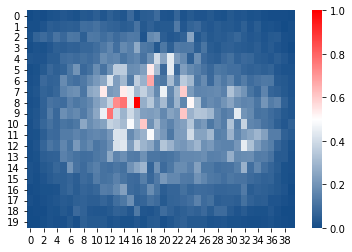

In [94]:
import matplotlib.colors as mcolors
# 自定义颜色映射列表，从蓝色到白色再到红色
colors = [mcolors.to_rgba('darkblue'), 'white', mcolors.to_rgba('darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])
# 创建热图并限制值范围

# sns.heatmap(new_cat_importance_dict['O=P1(O)OC2=C(C3=CC(COC)=CC=C3)C=C4C(CCCC4)=C2C5=C(O1)C(C6=CC=CC(COC)=C6)=CC7=C5CCCC7'][::-1], cbar=True, cmap=cmap)
sns.heatmap(new_imine_importance_dict['O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3'][::-1], cbar=True, cmap=cmap)
# plt.savefig("/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D/thiol_cnn.png", dpi=900, bbox_inches='tight')

<AxesSubplot:>

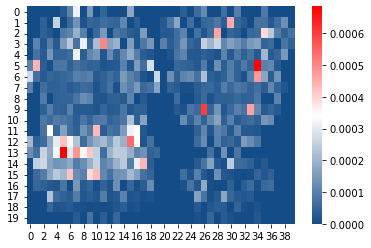

In [95]:
import matplotlib.colors as mcolors
# 自定义颜色映射列表，从蓝色到白色再到红色
colors = [mcolors.to_rgba('darkblue'), 'white', mcolors.to_rgba('darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, '#144C87'), (0.5, 'white'), (1, 'red')])
# 创建热图并限制值范围
sns.heatmap(importances_1[:, :, 1], cbar=True, cmap=cmap)
# plt.savefig("/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D/imine-rf.png", dpi=900, bbox_inches='tight')

In [96]:
importances_1[:, :, 0].shape

(20, 40)

### 9.3 特征重要性的矩阵图和四象限图

In [97]:
_, height, width, channel = importance_maps.shape

In [98]:

importances = feature_importances

importances_cat = importances[:, :, 0] 
importances_imine = importances[:, :, 1]
importances_thiol = importances[:, :, 2] 

In [99]:
importances_cat.shape

(20, 40)

<AxesSubplot:>

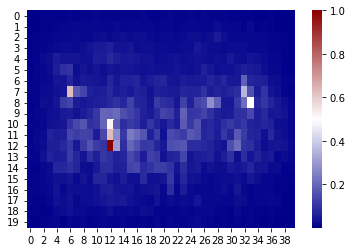

In [100]:
import matplotlib.colors as mcolors
# 自定义颜色映射列表，从蓝色到白色再到红色
colors = [mcolors.to_rgba('darkblue'), 'white', mcolors.to_rgba('darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
# 创建热图并限制值范围
sns.heatmap(importances_cat, cbar=True, cmap=cmap)

<AxesSubplot:>

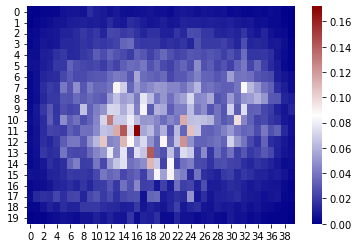

In [101]:
import matplotlib.colors as mcolors
# 自定义颜色映射列表，从蓝色到白色再到红色
colors = [mcolors.to_rgba('darkblue'), 'white', mcolors.to_rgba('darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
# 创建热图并限制值范围
sns.heatmap(importances_imine, cbar=True, cmap=cmap)

<AxesSubplot:>

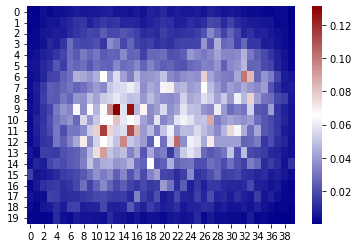

In [102]:
import matplotlib.colors as mcolors
# 自定义颜色映射列表，从蓝色到白色再到红色
colors = [mcolors.to_rgba('darkblue'), 'white', mcolors.to_rgba('darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
# 创建热图并限制值范围
sns.heatmap(importances_thiol, cbar=True, cmap=cmap)

In [103]:
# 划分四个象限，每个象限一个颜色
def devide4(average_colors, row, col):
    # 第一象限
    quadrant1 = average_colors[:row, col:]
    # 第二象限
    quadrant2 = average_colors[:row, :col]
    # 第三象限
    quadrant3 = average_colors[row:, :col]
    # 第四象限
    quadrant4 = average_colors[row:, col:]
    
    return quadrant1, quadrant2, quadrant3, quadrant4

In [104]:

importances = feature_importances

importances_cat = importances[:, :, 0]
importances_imine = importances[:, :, 1]
importances_thiol = importances[:, :, 2]
num_bins = 20
q_list = np.array([
    *devide4(importances_cat[:, :num_bins], row_cat, col_cat), 
    *devide4(importances_cat[:, num_bins:], row_cat, col_cat), 
    *devide4(importances_imine[:, :num_bins], row_imine, col_imine),
    *devide4(importances_imine[:, num_bins:], row_imine, col_imine),
    *devide4(importances_thiol[:, :num_bins], row_thiol, col_thiol),
    *devide4(importances_thiol[:, num_bins:], row_thiol, col_thiol)
])

# 将特征重要性分数按照四个区域对应的像素数量进行平均
num_regions = 24
region_feature_importance = np.zeros(num_regions)

for i in range(num_regions): 
    region_feature_importance[i] = np.mean(q_list[i]) 

# 打印每个区域的特征重要性得分
print('Cat:')
for i in range(8):
    print(f"Quadrant {i+1} Feature Importance: {region_feature_importance[i]:.4f}")
    
print('Imine:')
for i in range(8):
    print(f"Quadrant {i+1} Feature Importance: {region_feature_importance[8+i]:.4f}")
    
print('Thiol:')
for i in range(8):
    print(f"Quadrant {i+1} Feature Importance: {region_feature_importance[16+i]:.4f}")

Cat:
Quadrant 1 Feature Importance: 0.0586
Quadrant 2 Feature Importance: 0.0383
Quadrant 3 Feature Importance: 0.0350
Quadrant 4 Feature Importance: 0.0835
Quadrant 5 Feature Importance: 0.0450
Quadrant 6 Feature Importance: 0.0552
Quadrant 7 Feature Importance: 0.0504
Quadrant 8 Feature Importance: 0.0332
Imine:
Quadrant 1 Feature Importance: 0.0277
Quadrant 2 Feature Importance: 0.0134
Quadrant 3 Feature Importance: 0.0165
Quadrant 4 Feature Importance: 0.0444
Quadrant 5 Feature Importance: 0.0191
Quadrant 6 Feature Importance: 0.0261
Quadrant 7 Feature Importance: 0.0342
Quadrant 8 Feature Importance: 0.0180
Thiol:
Quadrant 1 Feature Importance: 0.0374
Quadrant 2 Feature Importance: 0.0173
Quadrant 3 Feature Importance: 0.0144
Quadrant 4 Feature Importance: 0.0289
Quadrant 5 Feature Importance: 0.0231
Quadrant 6 Feature Importance: 0.0341
Quadrant 7 Feature Importance: 0.0233
Quadrant 8 Feature Importance: 0.0126


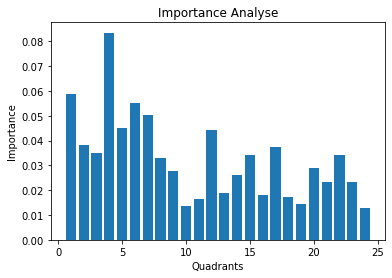

In [105]:
import matplotlib.pyplot as plt
# 创建一个表示象限的列表，从1到24
quadrants = list(range(1, 25))
# 绘制柱状图
plt.bar(quadrants, region_feature_importance)

# 添加横轴和纵轴标签
plt.xlabel("Quadrants")
plt.ylabel("Importance")

# 添加标题
plt.title("Importance Analyse")

# 显示柱状图
plt.show()

In [106]:
region_feature_importance

array([0.05860488, 0.03832525, 0.03502364, 0.08352159, 0.04504586,
       0.05518422, 0.05039772, 0.03315641, 0.02771085, 0.01343483,
       0.01650125, 0.04436471, 0.01906877, 0.02614786, 0.03421756,
       0.0179848 , 0.03738111, 0.01727283, 0.01435254, 0.02890325,
       0.02312243, 0.03411928, 0.02326836, 0.01262486])

In [107]:
# 对矩阵四个象限的区域进行对应的着色
def assign8(colors, row, col, importances):
    # 第一象限
    colors[:row, col:num_bins] = importances[0]
    # 第二象限
    colors[:row, :col] = importances[1]
    # 第三象限
    colors[row:, :col] = importances[2]
    # 第四象限        
    colors[row:, col:num_bins] = importances[3]
    
    # 第五象限
    colors[:row, num_bins+col:] = importances[4]
    # 第六象限
    colors[:row, num_bins:num_bins+col] = importances[5]
    # 第七象限
    colors[row:, num_bins:num_bins+col] = importances[6]
    # 第八象限
    colors[row:, num_bins+col:] = importances[7]
    
    return colors

In [108]:
cat_metric = assign8(np.zeros([height, width]), row_cat, col_cat, region_feature_importance[:8])
imine_metric = assign8(np.zeros([height, width]), row_imine, col_imine, region_feature_importance[8:16])
thiol_metric = assign8(np.zeros([height, width]), row_thiol, col_thiol, region_feature_importance[16:])

<AxesSubplot:>

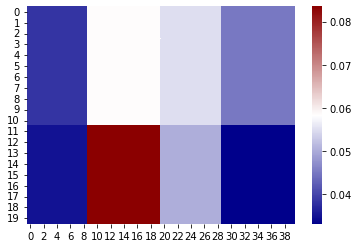

In [109]:
sns.heatmap(cat_metric,cbar=True,cmap=cmap) 

<AxesSubplot:>

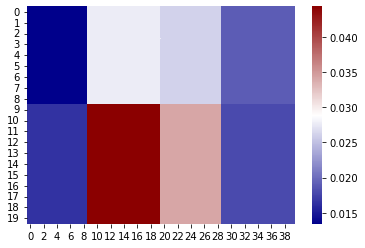

In [110]:
sns.heatmap(imine_metric,cbar=True,cmap=cmap) 

<AxesSubplot:>

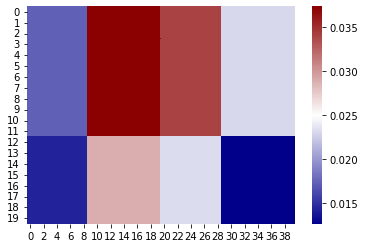

In [111]:
sns.heatmap(thiol_metric,cbar=True,cmap=cmap) 

### 9.4 特征重要性回溯到三维表面

In [112]:
%matplotlib notebook  

In [113]:
num_bins = 20

#### CPA

In [114]:
import numpy as np
import plotly.graph_objs as go

# Load your data
projected_points_list = np.load('./Jishe_new_81_1/cat_projected_points.npy', allow_pickle=True)
origin_cat = projected_points_list[22]

# 创建散点图数据
scatter = []
colors = ['red', 'green', 'blue', 'purple', 'cyan', 'magenta', 'black', 'yellow']
# 根据象限将数据点绘制成不同颜色的散点，并为每个象限创建标签
labels = ['Quadrant 1', 'Quadrant 2', 'Quadrant 3', 'Quadrant 4', 'Quadrant 5', 'Quadrant 6', 'Quadrant 7',
          'Quadrant 8']
    
    
# 确定每个数据点所在的象限
samples = origin_cat
quadrant = np.zeros(samples.shape[0], dtype=int)
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 1  # 第一象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 2  # 第二象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 3  # 第三象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 4  # 第四象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 5  # 第五象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 6  # 第六象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 7  # 第七象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 8  # 第八象限

for i in range(1, 9):
    subset = samples[quadrant == i]
    scatter.append(go.Scatter3d(
        x=subset[:, 0],
        y=subset[:, 1],
        z=subset[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors[i - 1],
            opacity=1.0
        ),
        name=f'Quadrant {i}'
    ))

# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Uniformly Sampled Points on the Surface of Cat',
    title_x=0.5  # 设置标题在X轴中央
    
)

# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows])
fig = go.Figure(data=[*scatter], layout=layout)
# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows], layout=layout)

# 显示图形
fig.show()
    

color_origin = []

# Save the plot as an HTML file
# fig.write_html("cat_point_plot.html")

In [115]:
len(cat_matric_list)

43

In [116]:
import math
import sympy as sp
from scipy.optimize import newton

# _, height, width, channel = react_spms_std.shape
importances = feature_importances.reshape(height, width, channel)

# cat
importances_cat_pos = importances[:, :num_bins, 0]  # 为了从上往下y坐标依次增大
importances_cat_neg = importances[:, num_bins:, 0]
x_cor_cat, y_cor_cat, z_cor_cat, color_cat = [], [], [], []

for cat_matric in cat_matric_list:
# for cat_matric in [cat_matric]:
    
    cat_z_pos = cat_matric[::-1, :num_bins] # 同样为了从上往下y坐标依次增大
    cat_z_neg = cat_matric[::-1, num_bins:]

    for y_index in range(importances_cat_pos.shape[0]):
        y_project = y_min_mid_cat + y_index * y_step_cat
        for x_index in range(importances_cat_pos.shape[1]):
            x_project = x_min_mid_cat + x_index * x_step_cat
            z_project = cat_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_cat_pos[y_index, x_index]
            
#             if (importance_color <= 0.15):
#                 continue

            if (importance_color <= 0.3): # v
                continue

            x_cor_cat.append(x_cor)
            y_cor_cat.append(y_cor)
            z_cor_cat.append(z_cor)
            color_cat.append(importance_color)

            print('coordinate', x_cor, y_cor, z_cor, importance_color)
        
print('+++++++++++++++++++++++++++++++++++')
for cat_matric in cat_matric_list:
# for cat_matric in [cat_matric]:
    
    cat_z_pos = cat_matric[::-1, :num_bins] # 同样为了从上往下y坐标依次增大
    cat_z_neg = cat_matric[::-1, num_bins:]
    
    for y_index in range(importances_cat_neg.shape[0]):
        y_project = y_min_mid_cat + y_index * y_step_cat
        for x_index in range(importances_cat_neg.shape[1]):
            x_project = x_min_mid_cat + x_index * x_step_cat
            z_project = cat_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_cat_pos[y_index, x_index]
            
#             if (importance_color <= 0.15):
#                 continue
                
            if (importance_color <= 0.3): # v
                continue

            x_cor_cat.append(x_cor)
            y_cor_cat.append(y_cor)
            z_cor_cat.append(-z_cor)
            color_cat.append(importance_color)

            print('coordinate', x_cor, y_cor, -z_cor, importance_color)

theta/2:  0.7762186200092767
theta/2:  0.6888040283598154
theta/2:  0.7837769036695577
theta/2:  0.7771714697665313
theta/2:  0.6445793409792782
theta/2:  0.5778778777575572
theta/2:  0.5423660478069012
theta/2:  0.6009108545363375
theta/2:  0.7676320344646634
theta/2:  0.7707810935596271
theta/2:  0.7794577675507326
theta/2:  0.7824124002666248
theta/2:  0.78315250940167
theta/2:  0.7673869637733126
theta/2:  0.7310954490486146
theta/2:  0.6196647091854239
coordinate -6.2203824826840695 -2.8574605434470013 2.355913332738927 0.6271257368804831
theta/2:  0.5223669339298512
theta/2:  0.4667906462789424
theta/2:  0.5233738614541454
theta/2:  0.7293587998584484
theta/2:  0.7381887444243401
theta/2:  0.7475636568658329
theta/2:  0.760064004627886
theta/2:  0.7703590702644789
theta/2:  0.7852044659313975
theta/2:  0.7733649897811766
theta/2:  0.7183466185403102
theta/2:  0.6730008857228273
theta/2:  0.6214082245857548
theta/2:  0.5265819201856566
theta/2:  0.3838524455071714
theta/2:  0.3624

theta/2:  0.7852966210538388
theta/2:  0.7852943374512862
theta/2:  0.7817226351587186
theta/2:  0.7790677438512933
theta/2:  0.7839754174583621
theta/2:  0.7847822006590318
theta/2:  0.7831356412378543
theta/2:  0.7834998990394222
theta/2:  0.7817092954861473
theta/2:  0.7641238956874583
theta/2:  0.7541605240472089
theta/2:  0.7607754655785344
theta/2:  0.7723307106319222
theta/2:  0.7737769752988313
theta/2:  0.7700363291780217
theta/2:  0.7815120700447724
theta/2:  0.784677190360981
theta/2:  0.7693618101688613
theta/2:  0.7396527918893423
theta/2:  0.7157939097180647
theta/2:  0.7322982847294639
theta/2:  0.7357013155485068
theta/2:  0.7159039180824496
theta/2:  0.7303256025139998
theta/2:  0.7697171804457666
theta/2:  0.7834693563499183
theta/2:  0.7600105950203945
theta/2:  0.7186007945356199
theta/2:  0.6691472957986172
theta/2:  0.6597544672352618
theta/2:  0.6721686904972649
theta/2:  0.671250507752604
theta/2:  0.6893439696849777
theta/2:  0.7342839181300999
theta/2:  0.7831

theta/2:  0.765998269499753
theta/2:  0.753762516506695
theta/2:  0.676523770088712
theta/2:  0.6085403546466103
theta/2:  0.523760754899997
theta/2:  0.3741648883291446
theta/2:  0.17089236921228068
theta/2:  0.3363339817462518
theta/2:  0.6865214452555254
theta/2:  0.7603204945579599
theta/2:  0.72036125235024
theta/2:  0.6869258136565686
theta/2:  0.7015539194769032
theta/2:  0.726574047827321
theta/2:  0.7659797937215226
theta/2:  0.7815584937418175
theta/2:  0.7724221827049983
theta/2:  0.7623951541367183
theta/2:  0.7106690299596925
theta/2:  0.6455506128272406
theta/2:  0.5420314552770339
theta/2:  0.4099209416159233
theta/2:  0.23164665180546906
theta/2:  0.40901502061871137
theta/2:  0.6386140899293569
theta/2:  0.6859935183510684
coordinate 4.268303622300398 0.7701242102562316 0.8738234249911286 0.5165851880083734
theta/2:  0.6758480728087634
theta/2:  0.6671757153944067
theta/2:  0.705972955955441
theta/2:  0.7450930875198066
theta/2:  0.7774991125847366
theta/2:  0.78463906

theta/2:  0.7825653554533292
theta/2:  0.7423319161232049
theta/2:  0.6730119691504377
theta/2:  0.6292848579573499
theta/2:  0.4939907435809684
theta/2:  0.3416115677351913
theta/2:  0.44616485103966713
theta/2:  0.5871505188829512
theta/2:  0.6295953392785987
coordinate 4.657120020583215 3.278354533059787 1.8344475273604168 1.0
theta/2:  0.7036710120835158
coordinate 5.744546995436901 2.9173960157895507 1.062600653673314 0.30790493584589557
theta/2:  0.7679547513080643
theta/2:  0.7848072478710449
theta/2:  0.7777978916356281
theta/2:  0.7475558314122807
theta/2:  0.7070955351859212
theta/2:  0.7084869182283324
theta/2:  0.5370057645162376
theta/2:  0.4082392067218922
theta/2:  0.4572523015105924
theta/2:  0.5954632524841199
theta/2:  0.660931676873707
theta/2:  0.6926304914173436
theta/2:  0.7464835164300921
theta/2:  0.7779324662003256
theta/2:  0.7847350839811194
theta/2:  0.776407994287859
theta/2:  0.7532498457489798
theta/2:  0.728155093576683
theta/2:  0.7571105846806471
theta

theta/2:  0.7249657610352744
theta/2:  0.7098716174433902
theta/2:  0.7108618918677962
theta/2:  0.7243516915404872
theta/2:  0.7597998226803193
theta/2:  0.7803693253944427
theta/2:  0.7681634618209309
theta/2:  0.7411818480255261
theta/2:  0.7395857688141372
theta/2:  0.7155738382148502
theta/2:  0.6975709199019924
theta/2:  0.6932219332943329
theta/2:  0.607464668741728
theta/2:  0.48620342069726386
theta/2:  0.34245539303426087
theta/2:  0.4779862733514189
theta/2:  0.6967880596498084
theta/2:  0.7640674364783712
coordinate 3.7163525662195904 2.6161063550147916 0.19400587056180224 1.0
theta/2:  0.7609493938935906
coordinate 5.182065137036036 2.6317368795763603 0.2844212921378283 0.30790493584589557
theta/2:  0.7393512133884087
theta/2:  0.7306950947533569
theta/2:  0.7325642601391535
theta/2:  0.7619437334352817
theta/2:  0.7811152294155485
theta/2:  0.7655044526177226
theta/2:  0.7265106779205442
theta/2:  0.7034580275517532
theta/2:  0.7026736166968117
theta/2:  0.701301657820601

theta/2:  0.7780892882903927
theta/2:  0.7773286329268674
theta/2:  0.7613270152987193
theta/2:  0.771877087268538
theta/2:  0.7849041477412736
theta/2:  0.766692645675244
theta/2:  0.7042968240248261
theta/2:  0.6939431361017588
theta/2:  0.7790534745092363
theta/2:  0.759722104914446
theta/2:  0.6871549451717892
theta/2:  0.6573156314524902
theta/2:  0.7783526957201377
coordinate -4.759231729346064 -2.1862509132813597 0.07380423970219348 0.6271257368804831
theta/2:  0.6973532862151941
theta/2:  0.6186121765504136
theta/2:  0.5681831855032942
theta/2:  0.726080680091204
theta/2:  0.7104267145713737
theta/2:  0.565846011189281
theta/2:  0.45487481639729266
theta/2:  0.3841045839866639
theta/2:  0.5065834015835184
theta/2:  0.7679567183477338
theta/2:  0.6703619886107298
theta/2:  0.5835958106589771
theta/2:  0.5156110706917543
theta/2:  0.3836479954996616
theta/2:  0.19706680754553033
theta/2:  0.3357104597495562
theta/2:  0.6870228762851179
theta/2:  0.7644108947977686
theta/2:  0.768

theta/2:  0.5133751005664449
theta/2:  0.5414656162033399
theta/2:  0.6826076686663545
theta/2:  0.7833887826936893
theta/2:  0.7809763666010318
theta/2:  0.779632179509
theta/2:  0.7824331766760824
theta/2:  0.7840728830946995
theta/2:  0.691837738711627
theta/2:  0.6479366465475885
theta/2:  0.6386656535738856
theta/2:  0.6992168269202532
theta/2:  0.7847993422360274
theta/2:  0.7852134663083388
theta/2:  0.7570692999793508
theta/2:  0.698637513262281
theta/2:  0.6767935487565532
theta/2:  0.7086672358166805
theta/2:  0.7582749441916388
theta/2:  0.7777996666275415
theta/2:  0.7793361805213579
theta/2:  0.7318126500767057
theta/2:  0.6655950810121106
theta/2:  0.715142642101381
theta/2:  0.7826768428597414
theta/2:  0.7844840160859317
theta/2:  0.6882808578189079
theta/2:  0.5999921266774754
theta/2:  0.6466986048880413
theta/2:  0.7382355473650444
theta/2:  0.7805920228588766
theta/2:  0.7765030707005911
theta/2:  0.7681041572332185
theta/2:  0.7845624786360224
theta/2:  0.607285127

theta/2:  0.3108176316235952
theta/2:  0.5185585596229507
theta/2:  0.653983022246398
theta/2:  0.605099180728339
coordinate 4.8219580331170135 2.1322053425236973 1.9881243177139922 0.6324410585322042
theta/2:  0.6081567201434528
theta/2:  0.6843676223234489
theta/2:  0.7498048126239636
theta/2:  0.7850879977226451
theta/2:  0.7647116470017464
theta/2:  0.738396824206939
theta/2:  0.6844134836635929
theta/2:  0.659575238841896
theta/2:  0.48522872437467574
theta/2:  0.3421713474172636
theta/2:  0.4963832781794275
theta/2:  0.6921145411084207
theta/2:  0.6602726450929028
coordinate 4.447037280402334 3.1304679206156947 1.3901005700707236 1.0
theta/2:  0.6465931285682827
coordinate 6.294584521033277 3.196735237312896 2.011823683619731 0.30790493584589557
theta/2:  0.7296986914494759
theta/2:  0.7726060572262088
theta/2:  0.7853841711088541
theta/2:  0.7755237775130448
theta/2:  0.7612418816355792
theta/2:  0.7439383945444429
theta/2:  0.538782200746078
theta/2:  0.3971964323453811
theta/2

theta/2:  0.6591326546226414
theta/2:  0.552324415882444
theta/2:  0.36849048567367904
theta/2:  0.2213305054155582
theta/2:  0.3821462108220279
theta/2:  0.5728972844791504
theta/2:  0.6414696569941168
coordinate 4.576247705248981 0.8256861418031823 1.3768155187649227 0.5165851880083734
theta/2:  0.7006979404390637
theta/2:  0.753737995220447
theta/2:  0.7821075584088152
theta/2:  0.7794004178811466
theta/2:  0.7604121907828609
theta/2:  0.6836987211560981
theta/2:  0.6221520022339992
theta/2:  0.3953996111267222
theta/2:  0.3126342016158128
theta/2:  0.5136746787145212
theta/2:  0.6242453498886076
theta/2:  0.6457149224086766
coordinate 4.547193644305833 2.0107082051088057 1.4262854267020248 0.6324410585322042
theta/2:  0.7066347396361947
theta/2:  0.7549432489026343
theta/2:  0.779901654863214
theta/2:  0.781962098259715
theta/2:  0.77164828292807
theta/2:  0.7348579568260397
theta/2:  0.6767406082378813
theta/2:  0.4911315754609319
theta/2:  0.34881492621817467
theta/2:  0.50238197

theta/2:  0.7721687788195394
theta/2:  0.777874204811815
theta/2:  0.7783358425975002
theta/2:  0.7846272478426803
theta/2:  0.7850298159201194
theta/2:  0.7780742565606895
theta/2:  0.7330829896873758
theta/2:  0.7008650405818299
theta/2:  0.7139470457278727
theta/2:  0.7455729921800681
theta/2:  0.7149828679492995
theta/2:  0.7388419591468381
theta/2:  0.7774406256718938
theta/2:  0.782978626716097
theta/2:  0.785057491427686
theta/2:  0.7842364637053554
theta/2:  0.7826644688001992
theta/2:  0.7544633271254607
theta/2:  0.6668116165543195
theta/2:  0.5889962897807357
theta/2:  0.6203211092001425
theta/2:  0.6773401539953124
theta/2:  0.6162405668444335
theta/2:  0.6886181950750085
theta/2:  0.7644176661873682
theta/2:  0.7822956345843561
theta/2:  0.7813088589041893
theta/2:  0.7733176647635247
theta/2:  0.7241100153273361
coordinate -5.266927497172976 -2.4194713991082133 0.7140398794605639 0.6271257368804831
theta/2:  0.6184124250918634
theta/2:  0.4805480669590917
theta/2:  0.4750

theta/2:  0.7845893225601848
theta/2:  0.7849498351256912
theta/2:  0.7811739923909563
theta/2:  0.7836514302935935
theta/2:  0.7506871760789249
theta/2:  0.7376663278892666
theta/2:  0.7695842204976854
theta/2:  0.7764518047942764
theta/2:  0.7817141886042833
theta/2:  0.7642774532846577
theta/2:  0.7005368098697017
theta/2:  0.5689664213830476
theta/2:  0.5081682141587096
theta/2:  0.6296022392489073
theta/2:  0.7748039278231951
theta/2:  0.757486872039235
theta/2:  0.7506290435064739
theta/2:  0.7640484464370516
theta/2:  0.7619499235649012
theta/2:  0.7127306566335566
theta/2:  0.6174579319873832
coordinate -6.239953305911638 -2.8664508033435965 2.3972744527073067 0.6271257368804831
theta/2:  0.5411823871532391
theta/2:  0.45236142273652646
theta/2:  0.4894951072971423
theta/2:  0.714836534985955
theta/2:  0.7019732066033689
theta/2:  0.7268895757485041
theta/2:  0.7340877254204448
theta/2:  0.7557999868560107
theta/2:  0.7811150329868645
theta/2:  0.7839642726366747
theta/2:  0.74

theta/2:  0.7806494528469464
theta/2:  0.7698236454073718
theta/2:  0.7139794969917862
theta/2:  0.6033824775133471
theta/2:  0.4801306165169975
theta/2:  0.4774607492018374
theta/2:  0.5955912899663636
theta/2:  0.7237508064926572
theta/2:  0.7634576567051684
coordinate 3.7206954204202716 2.6191634838180637 0.19979212802417956 1.0
theta/2:  0.7675893952435762
coordinate 5.116513285190987 2.598446054111396 0.20447847630615906 0.30790493584589557
theta/2:  0.7835473101455875
theta/2:  0.7780097728503494
theta/2:  0.769926186852197
theta/2:  0.6741255675786324
theta/2:  0.5399480562022513
theta/2:  0.4845693604169423
theta/2:  0.570266893284511
theta/2:  0.7230147163373793
theta/2:  0.7828727146046476
theta/2:  0.7850164841731431
theta/2:  0.7852525190494096
theta/2:  0.7850548609223303
theta/2:  0.7071395689922355
theta/2:  0.5925214298058198
theta/2:  0.5120197013053631
theta/2:  0.5566077537022022
theta/2:  0.6872312999787138
theta/2:  0.739048039255423
theta/2:  0.6824808433851881
th

theta/2:  0.6792285342309883
theta/2:  0.7389048849750691
coordinate 3.8952969848169525 1.7224482222161235 0.3971870145848852 0.6324410585322042
theta/2:  0.7072356497678979
theta/2:  0.7065641637189656
theta/2:  0.7382207697541163
theta/2:  0.7766552450112438
theta/2:  0.47742792859663163
theta/2:  0.3422537268524709
theta/2:  0.504669866901954
theta/2:  0.7160116404132
theta/2:  0.7596946844967555
coordinate 3.747489933006107 2.638025336509999 0.2358000588254634 1.0
theta/2:  0.7562812568440972
coordinate 5.228125412355396 2.655128813493797 0.3418522568252787 0.30790493584589557
theta/2:  0.7451505763233205
theta/2:  0.7611762038657494
theta/2:  0.7835088861883921
theta/2:  0.5339676331191149
theta/2:  0.3988871484184024
theta/2:  0.49830372221701924
theta/2:  0.7018760512294976
theta/2:  0.7853774974696317
theta/2:  0.7801444338735299
theta/2:  0.7824885235145281
theta/2:  0.6295136864865765
theta/2:  0.5776105834199955
theta/2:  0.5800521826875125
theta/2:  0.6795071873828993
theta

theta/2:  0.2962688855633316
theta/2:  0.19952029606154748
theta/2:  0.378359486189179
theta/2:  0.5571237480637342
theta/2:  0.6368753681941078
coordinate 4.607608183952877 0.8313444702709398 1.4331720013575058 0.5165851880083734
theta/2:  0.7045519314614218
theta/2:  0.7323448167423638
theta/2:  0.7521883556465593
theta/2:  0.7752407711599362
theta/2:  0.7850900184457544
theta/2:  0.7695197692676901
theta/2:  0.7318164235992659
theta/2:  0.6488357529660098
theta/2:  0.5812177189265666
theta/2:  0.5034236851815624
theta/2:  0.3804962484843044
theta/2:  0.34307190091903994
theta/2:  0.49667049620829695
theta/2:  0.6489555552251556
theta/2:  0.6924478115920368
coordinate 4.22314194460073 1.8674168780960605 0.8684412598273411 0.6324410585322042
theta/2:  0.7106301915048684
theta/2:  0.7255021323946186
theta/2:  0.7443505667511192
theta/2:  0.7714072430705143
theta/2:  0.7850391275535891
theta/2:  0.7850953862391965
theta/2:  0.7708123430255092
theta/2:  0.7275035542107722
theta/2:  0.656

theta/2:  0.6822623274805499
theta/2:  0.7374961071302035
theta/2:  0.7728526263980776
theta/2:  0.7847043848726345
theta/2:  0.7833035131197341
theta/2:  0.7832490015567205
theta/2:  0.785073419391303
theta/2:  0.7846685557929829
theta/2:  0.7618969752249317
theta/2:  0.7422986481860658
theta/2:  0.6557675230333309
theta/2:  0.6373528310442897
theta/2:  0.6388608403740036
theta/2:  0.6718000246799193
theta/2:  0.7692668339988539
theta/2:  0.7830462029254867
theta/2:  0.7811168390398898
theta/2:  0.781108920231491
theta/2:  0.7850635781320675
theta/2:  0.7613562643539299
theta/2:  0.7574830712924941
theta/2:  0.6426828931395003
theta/2:  0.5952067625515196
theta/2:  0.5709836711075804
theta/2:  0.6122311500350055
theta/2:  0.7199829741848041
theta/2:  0.7815299949096995
theta/2:  0.778970179781205
theta/2:  0.7809408833670277
theta/2:  0.7837178360170213
theta/2:  0.7850547162037994
theta/2:  0.7655706881660685
theta/2:  0.7521629755651945
theta/2:  0.6600031308235077
theta/2:  0.60978

theta/2:  0.7073875038275445
coordinate 5.708291357915427 2.8989834146672906 -1.0070710354563355 0.30790493584589557
theta/2:  0.7121636590627962
theta/2:  0.7518163924219468
theta/2:  0.7800502111863213
theta/2:  0.6167602481745048
theta/2:  0.48011877931098124
theta/2:  0.44107881572657986
theta/2:  0.6286708909060628
theta/2:  0.7733454164853926
theta/2:  0.7651817031806092
theta/2:  0.7517980359583004
theta/2:  0.7715006353736975
theta/2:  0.7728786854961485
theta/2:  0.6300093708559121
theta/2:  0.5054355885239068
theta/2:  0.5124932281454561
theta/2:  0.6313748270617562
theta/2:  0.7852374157415972
theta/2:  0.6595350148706315
theta/2:  0.5553594281174122
theta/2:  0.6401294169567561
theta/2:  0.6435614353910735
theta/2:  0.706966982912934
theta/2:  0.6679931535640924
theta/2:  0.6964970178063448
theta/2:  0.7366943792103011
theta/2:  0.7483674941707111
theta/2:  0.7325746067614284
theta/2:  0.736992850262803
theta/2:  0.7824938532193251
theta/2:  0.7833771050316497
theta/2:  0.7

theta/2:  0.7837489407574013
theta/2:  0.7683763507647979
theta/2:  0.7454328235340325
theta/2:  0.7212131209945531
theta/2:  0.7139977020292363
theta/2:  0.7091752944957431
theta/2:  0.7509721606068661
theta/2:  0.6131736116439509
theta/2:  0.4693477107196031
theta/2:  0.4402905184819736
theta/2:  0.5815383388988626
theta/2:  0.6781791081322054
theta/2:  0.6709669197800114
theta/2:  0.6689028577336327
theta/2:  0.674339332362448
theta/2:  0.7059826314148546
theta/2:  0.7492060281507897
theta/2:  0.778592271297531
theta/2:  0.7837885739279484
theta/2:  0.7725790742557423
theta/2:  0.7551284420754311
theta/2:  0.7558890676788561
theta/2:  0.7571499659139375
theta/2:  0.7685809517785338
theta/2:  0.6653581414510769
theta/2:  0.5529030239964821
theta/2:  0.5595482837986026
theta/2:  0.6153836746762096
theta/2:  0.7452000395056543
theta/2:  0.723360397088966
theta/2:  0.7040388423104077
theta/2:  0.7092171919631012
theta/2:  0.7213209167271315
theta/2:  0.7555357740401735
theta/2:  0.78279

theta/2:  0.7147704430905045
theta/2:  0.7616740292097843
theta/2:  0.7768162063581399
theta/2:  0.740410792355926
theta/2:  0.7351268858122633
theta/2:  0.7685707715861436
theta/2:  0.6669441789781109
theta/2:  0.5381476888708595
theta/2:  0.4494009771593338
theta/2:  0.6065596839487681
theta/2:  0.7131865177862781
theta/2:  0.6996233057558263
theta/2:  0.7267402458514055
theta/2:  0.7731162060050669
theta/2:  0.6788266589337473
theta/2:  0.5226464685234196
theta/2:  0.5007931657117634
theta/2:  0.6478732663456614
theta/2:  0.7469214204453541
theta/2:  0.7686016159089558
theta/2:  0.6778764779891603
theta/2:  0.5671712372927924
theta/2:  0.607239236554986
theta/2:  0.6519997446210085
theta/2:  0.7052241903160964
theta/2:  0.704817401850023
theta/2:  0.6774775431093485
theta/2:  0.7686021032983621
theta/2:  0.7224394418124062
theta/2:  0.7300767869963988
theta/2:  0.7199211017023488
theta/2:  0.7846571001297918
theta/2:  0.7846056615296295
theta/2:  0.784651680462775
theta/2:  0.783136

theta/2:  0.6451188238954536
theta/2:  0.6781214282515176
theta/2:  0.7373246785570154
theta/2:  0.7804620204462592
theta/2:  0.7808869446823671
theta/2:  0.7521811618302054
theta/2:  0.7197191710166696
theta/2:  0.6075586263807116
theta/2:  0.5994639725539972
theta/2:  0.15538766477775334
theta/2:  0.18078872911967347
theta/2:  0.36929665701070685
theta/2:  0.5147527328633862
theta/2:  0.5306590161396261
theta/2:  0.6449343630912752
theta/2:  0.721367799497925
theta/2:  0.7613449165386059
theta/2:  0.7849442882246779
theta/2:  0.7618730438782815
theta/2:  0.7046629466043051
theta/2:  0.5982859700594645
theta/2:  0.5299095624903598
theta/2:  0.5016314267750775
theta/2:  0.27965461479694526
theta/2:  0.20009713250905023
theta/2:  0.3295430185977163
theta/2:  0.5448708016643751
coordinate 5.213609894069077 0.9406845336110541 -2.7651948037994565 0.5165851880083734
theta/2:  0.6006176767851145
theta/2:  0.6885525126010487
theta/2:  0.7527823721799483
theta/2:  0.7853213738014815
theta/2:  

theta/2:  0.35764644203154894
theta/2:  0.4656178216517321
theta/2:  0.6523358634373069
coordinate 4.501740119511895 1.99060926444268 -1.3417479935508507 0.6324410585322042
theta/2:  0.6864493292776706
theta/2:  0.7536143940720728
theta/2:  0.7835118084875997
theta/2:  0.784134985692133
theta/2:  0.7776635162724348
theta/2:  0.7474507280635205
theta/2:  0.7333089255137026
theta/2:  0.6986861661000064
theta/2:  0.5596079109930712
theta/2:  0.4203886071102705
theta/2:  0.512442535624994
theta/2:  0.6862737356034393
coordinate 4.266345280813871 3.003270761573121 -1.0481122914657623 1.0
theta/2:  0.7233668009620553
coordinate 5.551949805576171 2.819584600059419 -0.7765133994064449 0.30790493584589557
theta/2:  0.759889420099775
theta/2:  0.7831931550419299
theta/2:  0.7739291634178957
theta/2:  0.7595465444267916
theta/2:  0.743470996351705
theta/2:  0.6784269813465099
theta/2:  0.5402142246356448
theta/2:  0.449806008135498
theta/2:  0.6079735429551458
theta/2:  0.7155016172486544
theta/2

theta/2:  0.7851862728399761
theta/2:  0.7691048691436565
theta/2:  0.773472206454209
theta/2:  0.7848986231748873
theta/2:  0.6725514841161052
theta/2:  0.5656885582492382
theta/2:  0.6140126808025884
theta/2:  0.6545886616008731
theta/2:  0.7837866350013
theta/2:  0.7073273715831987
theta/2:  0.673071743323944
theta/2:  0.6864771659000627
theta/2:  0.7040960321129408
theta/2:  0.7384038539999017
theta/2:  0.7367686922714355
theta/2:  0.7328847283514726
theta/2:  0.7745440058187099
theta/2:  0.7839186296756547
theta/2:  0.7796190917026173
theta/2:  0.7803039751653321
theta/2:  0.7853948931914118
theta/2:  0.5909794604409617
theta/2:  0.6583695639510107
theta/2:  0.7064691715420974
theta/2:  0.7098586997161971
theta/2:  0.702334529005979
theta/2:  0.5600725720701653
theta/2:  0.5458328549410021
theta/2:  0.6675865376450234
theta/2:  0.6755370232955982
theta/2:  0.7852239065120596
theta/2:  0.7781208804260918
theta/2:  0.7735009915999297
theta/2:  0.7419870575036687
theta/2:  0.46797271

theta/2:  0.4835861715180189
theta/2:  0.6541553486438308
coordinate 4.489220013908111 3.160162228469972 -1.4750705100872046 1.0
theta/2:  0.7412879508022338
coordinate 5.37587407777242 2.730163688857902 -0.533301592704561 0.30790493584589557
theta/2:  0.7315931616197774
theta/2:  0.584348914442677
theta/2:  0.5292740538137604
theta/2:  0.5695334851183692
theta/2:  0.6878325864760416
theta/2:  0.7819447707192528
theta/2:  0.7834184198307611
theta/2:  0.7171256859044646
theta/2:  0.6730502723795453
theta/2:  0.6194050007767344
theta/2:  0.6304734156233605
theta/2:  0.7187657151814527
theta/2:  0.7837099289705931
theta/2:  0.7224540562618961
theta/2:  0.6743192945211066
theta/2:  0.6401651650350676
theta/2:  0.6684999280741284
theta/2:  0.7464409621639062
theta/2:  0.7807772625121319
theta/2:  0.7378016835996403
theta/2:  0.6826117222549503
theta/2:  0.6700648675848806
theta/2:  0.7054142452032522
theta/2:  0.7586634266697019
theta/2:  0.7816931556116966
theta/2:  0.7548649186190995
thet

theta/2:  0.6304899735182585
theta/2:  0.7809886221696172
theta/2:  0.7846280397405337
theta/2:  0.7851832823570504
theta/2:  0.7833302597473337
theta/2:  0.7703030347495179
theta/2:  0.7408122514166533
theta/2:  0.7116836079362763
theta/2:  0.7019248233743625
theta/2:  0.7051030221102844
theta/2:  0.7206576747885597
theta/2:  0.4520963588837326
theta/2:  0.3706792685395408
theta/2:  0.42039287813051673
theta/2:  0.5513498255064742
theta/2:  0.6489075500913181
theta/2:  0.7408429851460168
theta/2:  0.7625849387676975
theta/2:  0.7836003948252821
theta/2:  0.7852537772321367
theta/2:  0.7851500187499748
theta/2:  0.7717740626068861
theta/2:  0.7472396334147099
theta/2:  0.7213069636181699
theta/2:  0.7019435896077063
theta/2:  0.7334165022189476
theta/2:  0.699453409280094
theta/2:  0.23599246568440774
theta/2:  0.25455984687652117
theta/2:  0.41461287814000103
theta/2:  0.5079449923352332
theta/2:  0.654765956404277
theta/2:  0.6924814051361767
theta/2:  0.7526310734761792
theta/2:  0.

theta/2:  0.6855625267581069
theta/2:  0.5321958243088335
theta/2:  0.5075197420367954
theta/2:  0.6410348582120766
theta/2:  0.7739573698719712
theta/2:  0.7694485550523279
theta/2:  0.7731148698849042
theta/2:  0.7844523453326562
theta/2:  0.681707692680378
theta/2:  0.571421664711636
theta/2:  0.6138512793952529
theta/2:  0.6742140992723202
theta/2:  0.7771364113647976
theta/2:  0.7800018333174066
theta/2:  0.7853678936629381
theta/2:  0.7103931848989467
theta/2:  0.6571219899139018
theta/2:  0.6816254845559667
theta/2:  0.7315973574067126
theta/2:  0.750382594375388
theta/2:  0.7312937182400165
theta/2:  0.7446875411973995
theta/2:  0.7791779449260089
theta/2:  0.7791363387037884
theta/2:  0.7844548821740095
theta/2:  0.7853554278173214
theta/2:  0.783981717377935
theta/2:  0.7849689377932733
theta/2:  0.7853879940190419
theta/2:  0.7817674134580556
theta/2:  0.7749298821118669
theta/2:  0.7813351125837619
theta/2:  0.778134692110493
theta/2:  0.7784431747275676
theta/2:  0.7834088

theta/2:  0.7221516757022927
coordinate -5.285166514222559 -2.4278498664638013 -0.7396494989630853 0.6271257368804831
theta/2:  0.6468749458015209
theta/2:  0.6358833544376525
theta/2:  0.7107452756090321
theta/2:  0.5467369628815737
theta/2:  0.5248318607947753
theta/2:  0.6292758347689281
theta/2:  0.7310769264045599
theta/2:  0.7819496065152339
theta/2:  0.7847120636656557
theta/2:  0.7712725618725341
theta/2:  0.7444565118442387
theta/2:  0.6880828423233732
theta/2:  0.608780190037595
theta/2:  0.6009993370232577
theta/2:  0.45346004390216366
theta/2:  0.342273714967234
theta/2:  0.405068440164271
theta/2:  0.5230793350064845
theta/2:  0.6804591034886577
theta/2:  0.7454936281701083
theta/2:  0.7708679383602454
theta/2:  0.78360885475144
theta/2:  0.7796331977055737
theta/2:  0.7583516829373775
theta/2:  0.714038424163152
theta/2:  0.6592980009607126
theta/2:  0.5959955119672271
theta/2:  0.6042132833062154
theta/2:  0.22551921455789228
theta/2:  0.21862869402042462
theta/2:  0.304

theta/2:  0.631771699178649
theta/2:  0.4220608964465167
theta/2:  0.3400440507625111
theta/2:  0.4126016425319735
theta/2:  0.5215441075329711
theta/2:  0.6168973898141903
theta/2:  0.7039319255982511
theta/2:  0.7412804312344664
theta/2:  0.7817818807714055
theta/2:  0.7850819263549115
theta/2:  0.7522450231569767
theta/2:  0.7066519371252018
theta/2:  0.6777882256075899
theta/2:  0.6935778606274497
theta/2:  0.6492037718198961
theta/2:  0.22877836876608795
theta/2:  0.24978063383351365
theta/2:  0.4138902972561042
theta/2:  0.5084688639385386
theta/2:  0.6479025650440929
theta/2:  0.6720530042224694
theta/2:  0.7392928771494379
theta/2:  0.7806136550201934
theta/2:  0.785003691923973
theta/2:  0.7663153266147876
theta/2:  0.7283598111629872
theta/2:  0.7251497929543029
theta/2:  0.719664353714497
theta/2:  0.6323043482285312
theta/2:  0.4029244014458614
theta/2:  0.2931111563186117
theta/2:  0.4242999077794008
theta/2:  0.567339487674248
coordinate 5.069999039802993 0.91477302273632

theta/2:  0.6456092530702948
theta/2:  0.5834468997389449
theta/2:  0.6198501863343123
theta/2:  0.7551034637257357
theta/2:  0.7658224603738402
theta/2:  0.7678316787512889
theta/2:  0.7640990510719988
coordinate -4.892961125883928 -2.2476822601751665 -0.2295101831618634 0.6271257368804831
theta/2:  0.7191410582445421
theta/2:  0.6785421208904502
theta/2:  0.44554753418824117
theta/2:  0.5260488251531595
theta/2:  0.5439939338069405
theta/2:  0.5854589336829925
theta/2:  0.6142663644320896
theta/2:  0.7619238452699977
theta/2:  0.7843070871247507
theta/2:  0.7479572657768753
theta/2:  0.7234396463737826
theta/2:  0.7377165076404364
theta/2:  0.7419870575036687
theta/2:  0.47312429536399186
theta/2:  0.2914029462526319
theta/2:  0.3851301265759898
theta/2:  0.5112045950093916
theta/2:  0.5480948709347598
theta/2:  0.5956492594866946
theta/2:  0.662134463414292
theta/2:  0.7408012420099656
theta/2:  0.6821179061729068
theta/2:  0.696874515974262
theta/2:  0.7549544480582816
theta/2:  0.

theta/2:  0.784428643710061
theta/2:  0.716831230964495
theta/2:  0.6175251190902579
theta/2:  0.6428601655558855
theta/2:  0.6642635755224593
theta/2:  0.6913482741609402
theta/2:  0.7458342607949998
theta/2:  0.7829357257734223
theta/2:  0.7762879294710512
theta/2:  0.7664170260625394
theta/2:  0.7604185828787389
theta/2:  0.7668191491356456
theta/2:  0.781964838106792
theta/2:  0.7835642404070187
theta/2:  0.7740599749013773
theta/2:  0.6934279607778961
theta/2:  0.6257724266027771
theta/2:  0.6092386843781225
theta/2:  0.6463542555161688
theta/2:  0.6906230005942012
theta/2:  0.7359597306007659
theta/2:  0.7823650210933395
theta/2:  0.7704317169358358
theta/2:  0.7625097261114724
theta/2:  0.756015585503205
theta/2:  0.7823817287311947
theta/2:  0.6732426760271902
theta/2:  0.6115012864477688
theta/2:  0.5947069087370802
theta/2:  0.5877644887534166
theta/2:  0.6780208190996537
theta/2:  0.695592286856075
theta/2:  0.7594925168311922
theta/2:  0.777206361131923
theta/2:  0.76469358

theta/2:  0.7835770368100269
theta/2:  0.743543308676691
theta/2:  0.7406182409891566
theta/2:  0.7629326568914552
theta/2:  0.776567787621024
theta/2:  0.7526872865881828
theta/2:  0.7572473013207177
theta/2:  0.6937788949551946
theta/2:  0.6837273437085846
theta/2:  0.7408450286092032
theta/2:  0.7832978479724436
theta/2:  0.7739092007024931
coordinate -4.8009319943182565 -2.2054067870786747 -0.12141957378601949 0.6271257368804831
theta/2:  0.7433507324606555
theta/2:  0.7306173442372569
theta/2:  0.709319737017455
theta/2:  0.6077361328734605
theta/2:  0.6379808876302548
theta/2:  0.7243143478971401
theta/2:  0.7747564411827857
theta/2:  0.773475913275147
theta/2:  0.7373531736748321
theta/2:  0.696796199018495
theta/2:  0.43044394889880516
theta/2:  0.3655401797661843
theta/2:  0.44913110374211546
theta/2:  0.6513478147455896
theta/2:  0.7639219676935487
theta/2:  0.7850907093653958
theta/2:  0.7741671055781137
theta/2:  0.7443268999425888
theta/2:  0.6805056827225379
theta/2:  0.2

In [119]:
%matplotlib inline 

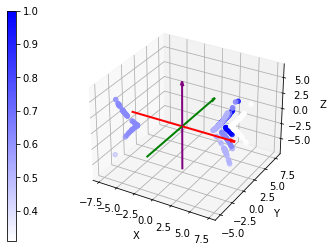

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# 自定义颜色映射
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'white'), (1, 'blue')])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
sc = ax.scatter(x_cor_cat, y_cor_cat, z_cor_cat, c=color_cat, marker='o', cmap=custom_cmap)

# 添加颜色条
cax = fig.add_axes([0.1, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cax, pad=0.1)

# 动态计算数据范围
x_range = np.ptp(x_cor_cat)  # x轴范围
y_range = np.ptp(y_cor_cat)  # y轴范围
z_range = np.ptp(z_cor_cat)  # z轴范围
max_range = max(x_range, y_range, z_range)

# 数据中心
x_center = np.mean(x_cor_cat)
y_center = np.mean(y_cor_cat)
z_center = np.mean(z_cor_cat)

# 动态调整箭头大小
arrow_scale = max_range * 0.5

# 添加自适应箭头
ax.quiver(0, 0, 0, arrow_scale, 0, 0, color='red', label='X+', linewidth=2, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, -arrow_scale, 0, 0, color='red', linewidth=2, arrow_length_ratio=0.0)
ax.quiver(0, 0, 0, 0, arrow_scale, 0, color='green', label='Y+', linewidth=2, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, -arrow_scale, 0, color='green', linewidth=2, arrow_length_ratio=0.0)
ax.quiver(0, 0, 0, 0, 0, arrow_scale, color='purple', label='Z+', linewidth=2, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 0, -arrow_scale, color='purple', linewidth=2, arrow_length_ratio=0.0)

# 设置坐标轴范围以居中散点
ax.set_xlim(-8, 8)
ax.set_ylim(y_center - max_range / 2, y_center + max_range / 2)
ax.set_zlim(z_center - max_range / 2, z_center + max_range / 2)

# 设置轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图形
plt.show()

# plt.savefig("/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D/cat_importance_plot_all.png", dpi=900, bbox_inches='tight')


In [121]:
x_cor_cat, y_cor_cat, z_cor_cat
x_tmp = np.array(x_cor_cat)
y_tmp = np.array(y_cor_cat)
z_tmp = np.array(z_cor_cat)
color_tmp = np.array(color_cat)

print((z_tmp[(color_tmp > 0.3) & (x_tmp > 0)]).max() - (z_tmp[(color_tmp > 0.3) & (x_tmp > 0)]).min())

# print(color_tmp.max())

# 1. 根据 x 坐标的正负进行分组
positive_x_indices = x_tmp > 0
negative_x_indices = x_tmp < 0

# 2. 获取 x 正半部分和负半部分的点
positive_x_points = (x_tmp[positive_x_indices], y_tmp[positive_x_indices], z_tmp[positive_x_indices])
negative_x_points = (x_tmp[negative_x_indices], y_tmp[negative_x_indices], z_tmp[negative_x_indices])

# 3. 找到正半部分 x 值最小的点
min_positive_x_index = np.argmin(positive_x_points[0])
min_positive_x_point = (positive_x_points[0][min_positive_x_index], 
                        positive_x_points[1][min_positive_x_index], 
                        positive_x_points[2][min_positive_x_index])

# 4. 找到负半部分 x 值最大的点
max_negative_x_index = np.argmax(negative_x_points[0])
max_negative_x_point = (negative_x_points[0][max_negative_x_index], 
                        negative_x_points[1][max_negative_x_index], 
                        negative_x_points[2][max_negative_x_index])

# 输出结果
print("The point with the smallest x in the positive x half:", min_positive_x_point)
print("The point with the largest x in the negative x half:", max_negative_x_point)

z_tmp = z_tmp[x_tmp>0]
print(z_tmp.shape)
print(z_tmp.max()-z_tmp.min())
print(x_tmp[x_tmp>0].min() - x_tmp[x_tmp<0].max())

z_tmp = np.array(z_cor_cat)
z_tmp = z_tmp[x_tmp<0]
print(z_tmp.shape)
print(z_tmp.max()-z_tmp.min())

8.917564480897678
The point with the smallest x in the positive x half: (3.5643856607042563, 2.5091300710948263, 5.730208479828303e-05)
The point with the largest x in the negative x half: (-4.703238944307037, -2.1605294766314236, -0.011177589418548569)
(334,)
8.917564480897678
8.267624605011292
(75,)
8.925160988392143


In [122]:
%matplotlib notebook 
plt.close('all')  # 关闭所有现有图形窗口

In [123]:
# 根据所有的分子结构将特征重要性回溯到三维表面
import numpy as np
import plotly.graph_objs as go

# 自定义颜色映射
color_scale = [[0, 'white'], [1, 'blue']]

# 根据 color_cat 的值将数据点绘制成不同颜色的散点
scatter = go.Scatter3d(
    x=x_cor_cat,
    y=y_cor_cat,
    z=z_cor_cat,
    mode='markers',
    marker=dict(
        size=4,
        color=color_cat,
        colorscale=color_scale,
        opacity=0.8,
        colorbar=dict(title='Color Legend'),
    ),
    showlegend=False  # 不显示箭头的图例
)

def create_arrow(x, y, z, color, name):
    arrow = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines+text',
        line=dict(color=color, width=6),
        text=['', name],
        textposition='bottom center',
         showlegend=False  # 不显示箭头的图例
    )
    return arrow

# Arrows for X, Y, and Z axes
arrow_x = create_arrow([-11, 11, 10.9, 11, 10.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-10, 10, 9.9, 10, 9.9], [0, 0, 0, 0, 0], 'green', 'Y')
arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], 'purple', 'Z')


# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Imortance on the Surface of CPA',
    title_x=0.5  # 设置标题在X轴中央
)

# 创建图表
fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

# 添加坐标轴
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))

# # 设置坐标轴标签
# fig.update_layout(scene=dict(
#     xaxis_title='X',
#     yaxis_title='Y',
#     zaxis_title='Z',
# ))

# 调整X轴和Y轴朝向
# 若要调整视角，可以使用以下代码：
# fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

# 显示交互式图
fig.show()

# Save the plot as an HTML file
# fig.write_html("/media/data1/Models_ly/3DChemical/denmark-2/spms-cnn-cat2-channel-20X40/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D/cat_importance_plot_all_1.html")
path = "/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D-v"
os.makedirs(path, exist_ok=True)
# fig.write_html("/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/cat_importance_plot_all.html")

In [124]:
# 根据每个分子结构分别将特征重要性回溯到三维表面
import math
import sympy as sp
from scipy.optimize import newton
import numpy as np


# path = "/media/data1/Models_ly/3DChemical/denmark-2/spms-cnn-cat2-channel-20X40/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D/cat_gradcam"
path = "/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/cat_grad"
os.makedirs(path, exist_ok=True)

num_bins = 20
index = 0
for tmp_key in cat_smiles_set:
    # 对应的所有构象的矩阵平均
    importances = new_cat_importance_dict[tmp_key]
    # cat
    importances_cat_pos = importances[:, :num_bins]  # 为了从上往下y坐标依次增大
    importances_cat_neg = importances[:, num_bins:]
    
    cat_matric = new_cat_desc_dict[tmp_key]
    
    
    x_cor_cat, y_cor_cat, z_cor_cat, color_cat = [], [], [], []

    print(tmp_key)
    
    cat_z_pos = cat_matric[::-1, :num_bins] # 同样为了从上往下y坐标依次增大
    cat_z_neg = cat_matric[::-1, num_bins:]

    for y_index in range(importances_cat_pos.shape[0]):
        y_project = y_min_mid_cat + y_index * y_step_cat
        for x_index in range(importances_cat_pos.shape[1]):
            x_project = x_min_mid_cat + x_index * x_step_cat
            z_project = cat_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

#             print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_cat_pos[y_index, x_index]

            x_cor_cat.append(x_cor)
            y_cor_cat.append(y_cor)
            z_cor_cat.append(z_cor)
            color_cat.append(importance_color)

#             print('coordinate', x_cor, y_cor, z_cor, importance_color)

    
    for y_index in range(importances_cat_neg.shape[0]):
        y_project = y_min_mid_cat + y_index * y_step_cat
        for x_index in range(importances_cat_neg.shape[1]):
            x_project = x_min_mid_cat + x_index * x_step_cat
            z_project = cat_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

#             print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_cat_pos[y_index, x_index]

            x_cor_cat.append(x_cor)
            y_cor_cat.append(y_cor)
            z_cor_cat.append(-z_cor)
            color_cat.append(importance_color)

#             print('coordinate', x_cor, y_cor, -z_cor, importance_color)

    import plotly.graph_objs as go
    # 自定义颜色映射
    color_scale = [[0, 'white'], [1, 'blue']]

    # 根据 color_cat 的值将数据点绘制成不同颜色的散点
    scatter = go.Scatter3d(
        x=x_cor_cat,
        y=y_cor_cat,
        z=z_cor_cat,
        mode='markers',
        marker=dict(
            size=4,
            color=color_cat,
            colorscale=color_scale,
            opacity=0.8,
            colorbar=dict(title='Color Legend'),
        ),
        showlegend=False  # 不显示箭头的图例
    )

    def create_arrow(x, y, z, color, name):
        arrow = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='lines+text',
            line=dict(color=color, width=6),
            text=['', name],
            textposition='bottom center',
            showlegend=False  # 不显示箭头的图例
        )
        return arrow

    # Arrows for X, Y, and Z axes
    arrow_x = create_arrow([-11, 11, 10.9, 11, 10.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
    arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-10, 10, 9.9, 10, 9.9], [0, 0, 0, 0, 0], 'green', 'Y')
    arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], 'purple', 'Z')


    # 创建图形布局
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
        ),
        title='Imortance on the Surface of CPA',
        title_x=0.5  # 设置标题在X轴中央
    )

    # 创建图表
    fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

    # 添加坐标轴
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ))

    # # 设置坐标轴标签
    # fig.update_layout(scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    # ))

    # 调整X轴和Y轴朝向
    # 若要调整视角，可以使用以下代码：
    # fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

    # 显示交互式图
#     fig.show()

    # Save the plot as an HTML file
    fig.write_html("{}/{}.html".format(path, index))
    
    index = index + 1

O=P1(O)OC2=C(C3=CC(C(F)(F)F)=CC(C(F)(F)F)=C3)C=C4C(CCCC4)=C2C5=C(O1)C(C6=CC(C(F)(F)F)=CC(C(F)(F)F)=C6)=CC7=C5CCCC7
O=P1(O)OC2=C(C3=CC(C(C)(C)C)=CC(C(C)(C)C)=C3)C=C4C(CCCC4)=C2C5=C(O1)C(C6=CC(C(C)(C)C)=CC(C(C)(C)C)=C6)=CC7=C5CCCC7
O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C(O1)C(C6=CC=CC=C6)=CC7=C5C=CC=C7
O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=C4)=C2C5=C(O1)C(C6=CC=C(C(C)(C)C)C=C6)=CC7=C5C=CC=C7
O=P1(O)OC2=C([Si](C3=CC=C(C(C)(C)C)C=C3)(C4=CC=C(C(C)(C)C)C=C4)C5=CC=C(C(C)(C)C)C=C5)C=C6C(CCCC6)=C2C7=C(O1)C([Si](C8=CC=C(C(C)(C)C)C=C8)(C9=CC=C(C(C)(C)C)C=C9)C%10=CC=C(C(C)(C)C)C=C%10)=CC%11=C7CCCC%11
O=P1(O)OC2=C(C3=C(OC)C=CC=C3OC)C=C4C(C=CC=C4)=C2C5=C(O1)[C@@]([C@@]6=C(OC)C=CC=C6OC)=CC7=C5C=CC=C7
O=P1(O)OC2=C(C3=C(C=CC4=CC=CC(C=C5)=C46)C6=C5C=C3)C=C7C(C=CC=C7)=C2C8=C(O1)C(C9=CC=C(C=C%10)C%11=C9C=CC%12=CC=CC%10=C%11%12)=CC%13=C8C=CC=C%13
O=P1(O)OC2=C(C3=C(C(C)C)C=C(C(C)C)C=C3C(C)C)C=C4C(C=CC=C4)=C2C5=C(O1)[C@@]([C@@]6=C(C(C)C)C=C(C(C)C)C=C6C(C)C)=CC7=C5C=CC=C7
O=P1(O)OC2=C(CC3=CC=C(

#### Imine

In [125]:
import numpy as np
import plotly.graph_objs as go

# Load your data
projected_points_list = np.load('./Jishe_new_81/imine_projected_points.npy', allow_pickle=True)
origin_imine = projected_points_list[22]

# 创建散点图数据
scatter = []
colors = ['red', 'green', 'blue', 'purple', 'cyan', 'magenta', 'black', 'yellow']
# 根据象限将数据点绘制成不同颜色的散点，并为每个象限创建标签
labels = ['Quadrant 1', 'Quadrant 2', 'Quadrant 3', 'Quadrant 4', 'Quadrant 5', 'Quadrant 6', 'Quadrant 7',
          'Quadrant 8']
    
    
# 确定每个数据点所在的象限
samples = origin_imine
quadrant = np.zeros(samples.shape[0], dtype=int)
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 1  # 第一象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 2  # 第二象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 3  # 第三象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 4  # 第四象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 5  # 第五象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 6  # 第六象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 7  # 第七象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 8  # 第八象限

for i in range(1, 9):
    subset = samples[quadrant == i]
    scatter.append(go.Scatter3d(
        x=subset[:, 0],
        y=subset[:, 1],
        z=subset[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors[i - 1],
            opacity=1.0
        ),
        name=f'Quadrant {i}'
    ))

# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Uniformly Sampled Points on the Surface of Imine',
    title_x=0.5  # 设置标题在X轴中央
    
)

# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows])
fig = go.Figure(data=[*scatter], layout=layout)
# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows], layout=layout)

# 显示图形
fig.show()
    

color_origin = []

# Save the plot as an HTML file
# fig.write_html("imine_point_plot.html")

In [126]:
import math
import sympy as sp
from scipy.optimize import newton

importances = feature_importances

# imine
importances_imine_pos = importances[:, :num_bins, 1]  # 为了从上往下y坐标依次增大
importances_imine_neg = importances[:, num_bins:, 1]
x_cor_imine, y_cor_imine, z_cor_imine, color_imine = [], [], [], []

for imine_matric in imine_matric_list:
    
    imine_z_pos = imine_matric[::-1, :num_bins] # 同样为了从上往下y坐标依次增大
    imine_z_neg = imine_matric[::-1, num_bins:]

    for y_index in range(importances_imine_pos.shape[0]):
        y_project = y_min_mid_imine + y_index * y_step_imine
        for x_index in range(importances_imine_pos.shape[1]):
            x_project = x_min_mid_imine + x_index * x_step_imine
            z_project = imine_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_imine_pos[y_index, x_index]
            
            if (importance_color <= 0.04): # v
                continue

            x_cor_imine.append(x_cor)
            y_cor_imine.append(y_cor)
            z_cor_imine.append(z_cor)
            color_imine.append(importance_color)

            print('coordinate', x_cor, y_cor, z_cor, importance_color)
        
print('+++++++++++++++++++++++++++++++++++')
for imine_matric in imine_matric_list:
    
    imine_z_pos = imine_matric[::-1, :num_bins] # 同样为了从上往下y坐标依次增大
    imine_z_neg = imine_matric[::-1, num_bins:]
    
    for y_index in range(importances_imine_neg.shape[0]):
        y_project = y_min_mid_imine + y_index * y_step_imine
        for x_index in range(importances_imine_neg.shape[1]):
            x_project = x_min_mid_imine + x_index * x_step_imine
            z_project = imine_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_imine_pos[y_index, x_index]
            
            if (importance_color <= 0.04): # v
                continue

            x_cor_imine.append(x_cor)
            y_cor_imine.append(y_cor)
            z_cor_imine.append(-z_cor)
            color_imine.append(importance_color)

            print('coordinate', x_cor, y_cor, -z_cor, importance_color)

theta/2:  0.7599759632352526
theta/2:  0.731764191767665
theta/2:  0.7098196490182187
theta/2:  0.7168448816713323
theta/2:  0.7599294932974076
theta/2:  0.7379714720135551
theta/2:  0.7196570855095823
theta/2:  0.7065467965782108
theta/2:  0.6659266182000126
theta/2:  0.6427510942200886
theta/2:  0.6593632013353811
theta/2:  0.6283975814772514
theta/2:  0.6849280549346737
theta/2:  0.6440862561712651
theta/2:  0.6819342037094549
theta/2:  0.6729019050220397
theta/2:  0.6894074002700187
theta/2:  0.7297218741924791
theta/2:  0.7316833756973217
theta/2:  0.6923846210850855
theta/2:  0.6901423277566562
theta/2:  0.6280523408762139
theta/2:  0.696879317459766
theta/2:  0.6655965121609951
theta/2:  0.5841181292529859
theta/2:  0.5717603583091836
theta/2:  0.6695768263896311
theta/2:  0.571648788859893
theta/2:  0.5717747310599129
theta/2:  0.5841410318928247
theta/2:  0.6501171655065484
theta/2:  0.754208912983095
theta/2:  0.6899338348374789
theta/2:  0.70009429596258
theta/2:  0.70777920

theta/2:  0.7853981633974361
coordinate 0.004176323699043746 0.0007942604625980154 1.0409497792752508e-16 0.04354349181155835
theta/2:  0.7836635455587972
theta/2:  0.6740587997909582
theta/2:  0.547121853977766
theta/2:  0.4646087258002501
theta/2:  0.40313813212384053
theta/2:  0.3528453074929682
theta/2:  0.30657585826481204
coordinate -0.7573512480320288 1.8304058441534485 2.815296521913118 0.040641511341044004
theta/2:  0.2741371002081554
theta/2:  0.2667079311342571
coordinate -0.14509383567772394 1.873941530315488 3.182901383101575 0.0487401041971184
theta/2:  0.26917641396210373
coordinate 0.16981124256990046 1.8714032828514788 3.146541321127221 0.0623695159573068
theta/2:  0.2786122018317802
coordinate 0.481957612393221 1.861507152986833 3.0860508847296972 0.1051292389745746
theta/2:  0.3082504059729097
coordinate 0.7808886548593169 1.8284606758295505 2.8056989828376233 0.0441425777822078
theta/2:  0.3655198621254431
coordinate 1.0455660326683038 1.7565408988311486 2.279429291

theta/2:  0.6945037848998011
coordinate 1.7074274487265055 3.6675686791520734 0.7436429832401127 0.04241710204637832
theta/2:  0.7398267981419364
theta/2:  0.7026978815998515
theta/2:  0.6867333502727814
theta/2:  0.6480109919871316
theta/2:  0.6552859712292403
theta/2:  0.7123124860131246
theta/2:  0.5940355687895219
theta/2:  0.7116945810736761
theta/2:  0.5932276750542063
theta/2:  0.6809671866082164
theta/2:  0.673719785032359
theta/2:  0.6814935177425179
theta/2:  0.6748953513535115
theta/2:  0.6480996308885449
theta/2:  0.6833226249703868
theta/2:  0.7398755545916905
theta/2:  0.7101870904223172
theta/2:  0.7095804764529389
theta/2:  0.7085966413035237
theta/2:  0.6850010196936906
theta/2:  0.6802378296384933
theta/2:  0.6844196663353593
theta/2:  0.7076268673704291
theta/2:  0.6945433910180975
theta/2:  0.709087764360905
theta/2:  0.7096258540880118
theta/2:  0.7453932666975427
theta/2:  0.7500995528793258
theta/2:  0.774148831905191
theta/2:  0.7193538405504668
theta/2:  0.7312

theta/2:  0.366000311963615
coordinate 1.0451813161060215 1.7558945786992846 2.2741902871833224 0.047207942045269756
theta/2:  0.4170440152267899
coordinate 1.2851309664346457 1.6834116034823423 1.9210729760138143 0.11026581864625025
theta/2:  0.48442289908718345
coordinate 1.4691689207239191 1.5770793308881772 1.4807506845048224 0.08801240943845591
theta/2:  0.5360921410232481
coordinate 1.6368864611598186 1.4884264405991843 1.2046674030073896 0.058579483930703675
theta/2:  0.6749579318539757
coordinate 1.556380931400977 1.2275168055269616 0.4450914338202677 0.07372811438069536
theta/2:  0.6820931573531471
coordinate 1.7426435389053843 1.2134748097280956 0.4450914338202677 0.0492762118882901
theta/2:  0.7840623216281497
theta/2:  0.784311296849743
theta/2:  0.7007424446269751
theta/2:  0.6175758087479609
theta/2:  0.5347509975124682
theta/2:  0.4881618701297326
theta/2:  0.45014680773858246
theta/2:  0.44290115685814047
theta/2:  0.4382492059498865
theta/2:  0.4034760743629251
theta/2

theta/2:  0.21537117752132
theta/2:  0.2260838722437933
coordinate 0.8168369547692917 -3.403739140987965 7.2064109128758345 0.051203812065217125
theta/2:  0.24215078110867436
coordinate 1.1297874531580616 -3.3777533057456637 6.770108187461787 0.06457995024393112
theta/2:  0.30437631870416754
coordinate 1.3992874350722027 -3.2619270352870187 5.091916379632191 0.05339256059837445
theta/2:  0.3215972272401556
coordinate 1.6886015808735806 -3.225769853122033 4.857785057839842 0.057677164506279785
theta/2:  0.546590839422124
coordinate 1.6163507725994146 -2.615584859427103 1.5914195264467352 0.04141243376055707
theta/2:  0.6694711641069231
coordinate 1.5700330963429585 -2.2036607315765377 0.6388289910055127 0.07716633237971506
theta/2:  0.7853981633974361
theta/2:  0.6096404536499921
theta/2:  0.5855339835112366
theta/2:  0.31100524312217603
theta/2:  0.2518523178896918
theta/2:  0.1877923726354862
theta/2:  0.16935843373398066
theta/2:  0.15379791422027028
coordinate -0.4829773950306674 -2

theta/2:  0.7639398387693668
theta/2:  0.7170935918368998
theta/2:  0.7287259409516996
theta/2:  0.7061703622613489
theta/2:  0.7061005257555882
theta/2:  0.7061034078546581
theta/2:  0.7061789834051145
theta/2:  0.7391402248585879
theta/2:  0.7730802026934841
theta/2:  0.7291125464198053
theta/2:  0.7478482256473403
theta/2:  0.7807254092616526
theta/2:  0.7671487209044131
theta/2:  0.7503909461613778
theta/2:  0.7385774272781089
theta/2:  0.767281439825804
theta/2:  0.5864751747726125
theta/2:  0.5966919900937865
theta/2:  0.5993031404394092
theta/2:  0.6019502220904954
theta/2:  0.612942729249278
theta/2:  0.6042299952466115
theta/2:  0.6071460509122054
theta/2:  0.5915547990468653
theta/2:  0.6136564372433272
theta/2:  0.5753305663118282
theta/2:  0.5922858640318117
theta/2:  0.5476476564984994
theta/2:  0.6276708994245125
theta/2:  0.5574826314746324
theta/2:  0.6981016428819624
theta/2:  0.5500078733095256
theta/2:  0.525667367646562
theta/2:  0.598830577818998
theta/2:  0.578368

theta/2:  0.5393731298941388
theta/2:  0.5079736685084064
theta/2:  0.479410978670956
theta/2:  0.47254438187262565
coordinate -0.6606251899466669 3.8156407028258856 2.7980501046388406 0.04296390676514455
theta/2:  0.4507824899307527
theta/2:  0.44711992405682327
theta/2:  0.44988948881910235
theta/2:  0.45439795515290116
theta/2:  0.47482192486887775
coordinate 0.6802908029305235 3.8067416694551732 2.7674556618103674 0.051985406909783295
theta/2:  0.4786017868885841
coordinate 0.9444712977964623 3.791908593505757 2.75215844039613 0.06645658481666036
theta/2:  0.5788894363231186
coordinate 1.0772177788571562 3.3721643717067877 1.5513287958509239 0.07524497327689403
theta/2:  0.5396855071250262
theta/2:  0.5941584053051273
coordinate 1.5206316811967606 3.304419293199654 1.4633378504361654 0.0420388429138869
theta/2:  0.6836752926840378
coordinate 1.5346218090589867 2.892512245893476 0.6755082245169971 0.04702518457899739
theta/2:  0.784285344443082
coordinate 1.4492236572914172 2.411681

theta/2:  0.6475016364151903
theta/2:  0.6473347016438278
theta/2:  0.6282040931832874
theta/2:  0.6407503455673657
theta/2:  0.6665648538970366
coordinate 0.5312704622418724 -2.2137907157912187 -0.551506123530224 0.051203812065217125
theta/2:  0.6974583468763041
coordinate 0.7042286147703937 -2.1054495913299864 -0.39454752415374 0.06457995024393112
theta/2:  0.7366167305296516
coordinate 0.8435627056831226 -1.9664580176021236 -0.20942560991195122 0.05339256059837445
theta/2:  0.7062899773032739
theta/2:  0.5582156640775066
theta/2:  0.6210839087514614
theta/2:  0.4573853736070243
theta/2:  0.45930856488696187
theta/2:  0.48611756645073173
coordinate -0.38662995181661997 -1.7076128295939388 -1.1941163515556172 0.06475792900797515
theta/2:  0.3986640942438698
theta/2:  0.37789899771824886
coordinate 0.15785765446997738 -1.887029426662624 -2.0091778740477717 0.042906945055784344
theta/2:  0.4484525902897955
coordinate 0.423380281287279 -1.7737751745063417 -1.4563429248820516 0.0494843756

theta/2:  0.7618654100966071
theta/2:  0.7454062311153038
theta/2:  0.7780780874131904
theta/2:  0.7360434582783688
theta/2:  0.7356751206980852
theta/2:  0.73581220370381
theta/2:  0.7256104022099671
coordinate -0.8453794665952138 -2.7888443489221455 -0.35013237371789746 0.0404063691483623
theta/2:  0.7246909978335137
theta/2:  0.6793613733590136
theta/2:  0.6789715414443651
coordinate -0.09443189124062663 -3.0179705857327463 -0.6525845557055148 0.042188580689617505
theta/2:  0.6789876998200791
theta/2:  0.6794092521791453
theta/2:  0.7012778525367518
theta/2:  0.725690983467189
coordinate 0.8602605680655356 -2.7884456571019 -0.35013237371789746 0.06926630224635749
theta/2:  0.7259097927103529
theta/2:  0.7059069260924677
theta/2:  0.6463450206642697
theta/2:  0.6472909074581417
theta/2:  0.6281609424057175
theta/2:  0.6406974012991797
theta/2:  0.6665189663733485
coordinate 0.5313088181699154 -2.2139505439831324 -0.5517671617096422 0.051203812065217125
theta/2:  0.6973786494272002
co

theta/2:  0.7412793143654146
theta/2:  0.7039563367170641
theta/2:  0.7390080048037381
theta/2:  0.7394486904949877
theta/2:  0.7816548247320733
theta/2:  0.7821053855243878
theta/2:  0.783728106553886
theta/2:  0.7439117082002511
theta/2:  0.7235779902426247
theta/2:  0.7234064048706109
theta/2:  0.7012492751762366
theta/2:  0.7011756869423593
theta/2:  0.723823893749586
theta/2:  0.7012583595221968
theta/2:  0.7234179224756262
theta/2:  0.7238255364665653
theta/2:  0.7590063160123484
theta/2:  0.7441642569755803
theta/2:  0.7820525027830719
theta/2:  0.7820788592706177
theta/2:  0.7824102130455656
theta/2:  0.7792969415475056
theta/2:  0.7617471526455522
theta/2:  0.7452945626312714
theta/2:  0.779253748844495
theta/2:  0.7374903440434187
theta/2:  0.7371319001413283
theta/2:  0.7372653024554082
theta/2:  0.7273329540547342
coordinate -0.8427954945012561 -2.7803200160553563 -0.33891294951610196 0.0404063691483623
theta/2:  0.7264373975749276
theta/2:  0.6808821363834469
theta/2:  0.6

theta/2:  0.5912923129916443
theta/2:  0.658359460763774
theta/2:  0.5904760879042676
theta/2:  0.6320289750401512
theta/2:  0.7342375539012987
theta/2:  0.6327474816797535
theta/2:  0.6878574107108297
theta/2:  0.6514407249746362
theta/2:  0.6693876448641979
coordinate 1.3619743826817903 4.68084793531442 -1.1518389349113975 0.04556403783829706
theta/2:  0.7467634845972888
theta/2:  0.784246722351703
theta/2:  0.7844023047938092
theta/2:  0.74177713980015
theta/2:  0.7467505166423473
theta/2:  0.7462158858676957
theta/2:  0.7314386855430455
theta/2:  0.6769509158646418
theta/2:  0.7008703232674366
theta/2:  0.7310377368340876
theta/2:  0.676718238278686
theta/2:  0.7314574748259932
theta/2:  0.677854745309491
theta/2:  0.73856733665907
theta/2:  0.7060755172051386
theta/2:  0.741392028982388
theta/2:  0.7418118001154685
theta/2:  0.7844032407809918
theta/2:  0.7845235691332256
theta/2:  0.7849992001055576
theta/2:  0.7465365141334256
theta/2:  0.7460612941393712
theta/2:  0.72613181119

theta/2:  0.5802181063921018
theta/2:  0.5506692916293999
theta/2:  0.5234073484771676
theta/2:  0.5143933618164783
theta/2:  0.5041577735594076
theta/2:  0.500633861334279
theta/2:  0.5036650169666907
theta/2:  0.4952963230428532
theta/2:  0.5144954508484626
theta/2:  0.5442992815508126
theta/2:  0.6023874503204709
theta/2:  0.6807172753026879
theta/2:  0.6059368697295034
theta/2:  0.6847758862078421
theta/2:  0.7166656347091868
coordinate 1.6441551480617407 3.531659239281545 -0.5389105845889834 0.04241710204637832
theta/2:  0.7813995922073059
theta/2:  0.7329172705460736
theta/2:  0.7320668814204355
theta/2:  0.6833799882776175
theta/2:  0.6616750308661006
theta/2:  0.6431137986977105
theta/2:  0.6868565156633109
theta/2:  0.5743611787880629
theta/2:  0.6860568472770121
theta/2:  0.5889923082783325
theta/2:  0.6501747567646331
theta/2:  0.6616911640740215
theta/2:  0.6508253559351851
theta/2:  0.6794566220879059
theta/2:  0.6443904682807666
theta/2:  0.6628687024625078
coordinate 1.3

In [128]:
%matplotlib inline 

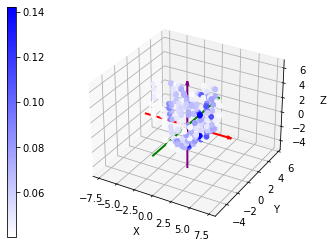

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# 自定义颜色映射
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'white'), (1, 'blue')])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
sc = ax.scatter(x_cor_imine, y_cor_imine, z_cor_imine, c=color_imine, marker='o', cmap=custom_cmap)

# 添加颜色条
cax = fig.add_axes([0.1, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cax, pad=0.1)

# 动态计算数据范围
x_range = np.ptp(x_cor_imine)  # x轴范围
y_range = np.ptp(y_cor_imine)  # y轴范围
z_range = np.ptp(z_cor_imine)  # z轴范围
max_range = max(x_range, y_range, z_range)

# 数据中心
x_center = np.mean(x_cor_imine)
y_center = np.mean(y_cor_imine)
z_center = np.mean(z_cor_imine)

# 动态调整箭头大小
arrow_scale = max_range * 0.5

# 添加自适应箭头
ax.quiver(0, 0, 0, arrow_scale, 0, 0, color='red', label='X+', linewidth=2, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, -arrow_scale, 0, 0, color='red', linewidth=2, arrow_length_ratio=0.0)
ax.quiver(0, 0, 0, 0, arrow_scale, 0, color='green', label='Y+', linewidth=2, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, -arrow_scale, 0, color='green', linewidth=2, arrow_length_ratio=0.0)
ax.quiver(0, 0, 0, 0, 0, arrow_scale, color='purple', label='Z+', linewidth=2, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 0, -arrow_scale, color='purple', linewidth=2, arrow_length_ratio=0.0)

# 设置坐标轴范围以居中散点
ax.set_xlim(-8, 8)
ax.set_ylim(y_center - max_range / 2, y_center + max_range / 2)
ax.set_zlim(z_center - max_range / 2, z_center + max_range / 2)

# 设置轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图形
plt.show()

# plt.savefig("/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D/imine_importance_plot_all.png", dpi=900, bbox_inches='tight')


In [130]:
%matplotlib notebook

In [131]:
import numpy as np
import plotly.graph_objs as go

# 自定义颜色映射
color_scale = [[0, 'white'], [1, 'blue']]

# 根据 color_cat 的值将数据点绘制成不同颜色的散点
scatter = go.Scatter3d(
    x=x_cor_imine,
    y=y_cor_imine,
    z=z_cor_imine,
    mode='markers',
    marker=dict(
        size=4,
        color=color_imine,
        colorscale=color_scale,
        opacity=0.8,
        colorbar=dict(title='Color Legend')
    ),
    showlegend=False  # 不显示箭头的图例
)

def create_arrow(x, y, z, color, name):
    arrow = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines+text',
        line=dict(color=color, width=6),
        text=['', name],
        textposition='bottom center',
        showlegend=False  # 不显示箭头的图例
    )
    return arrow

# Arrows for X, Y, and Z axes
arrow_x = create_arrow([-2, 2, 1.9, 2, 1.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], [0, 0, 0, 0, 0], 'green', 'Y')
arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-3, 9, 8.9, 9, 8.9], 'purple', 'Z')


# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Imortance on the Surface of Imine',
    title_x=0.5  # 设置标题在X轴中央
)

# 创建图表
fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)


# 添加坐标轴
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))

# # 设置坐标轴标签
# fig.update_layout(scene=dict(
#     xaxis_title='X',
#     yaxis_title='Y',
#     zaxis_title='Z',
# ))

# 调整X轴和Y轴朝向
# 若要调整视角，可以使用以下代码：
# fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

# 显示交互式图
fig.show()

# Save the plot as an HTML file
# fig.write_html("/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/imine_importance_plot_all.html")

In [132]:
import math
import sympy as sp
from scipy.optimize import newton
import numpy as np

path = "/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/imine_gradcam"
os.makedirs(path, exist_ok=True)

num_bins = 20
index = 0
for tmp_key in imine_smiles_set:
    # 对应的所有构象的矩阵平均
    importances = new_imine_importance_dict[tmp_key]
    # cat
    importances_imine_pos = importances[:, :num_bins]  # 为了从上往下y坐标依次增大
    importances_imine_neg = importances[:, num_bins:]
    
    imine_matric = new_imine_desc_dict[tmp_key]
    
    
    x_cor_imine, y_cor_imine, z_cor_imine, color_imine = [], [], [], []

    print(tmp_key)
    
    imine_z_pos = imine_matric[::-1, :num_bins] # 同样为了从上往下y坐标依次增大
    imine_z_neg = imine_matric[::-1, num_bins:]

    for y_index in range(importances_imine_pos.shape[0]):
        y_project = y_min_mid_imine + y_index * y_step_imine
        for x_index in range(importances_imine_pos.shape[1]):
            x_project = x_min_mid_imine + x_index * x_step_imine
            z_project = imine_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

#             print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_imine_pos[y_index, x_index]

            x_cor_imine.append(x_cor)
            y_cor_imine.append(y_cor)
            z_cor_imine.append(z_cor)
            color_imine.append(importance_color)

#             print('coordinate', x_cor, y_cor, z_cor, importance_color)

    
    for y_index in range(importances_imine_neg.shape[0]):
        y_project = y_min_mid_imine + y_index * y_step_imine
        for x_index in range(importances_imine_neg.shape[1]):
            x_project = x_min_mid_imine + x_index * x_step_imine
            z_project = imine_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

#             print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_imine_pos[y_index, x_index]

            x_cor_imine.append(x_cor)
            y_cor_imine.append(y_cor)
            z_cor_imine.append(-z_cor)
            color_imine.append(importance_color)

#             print('coordinate', x_cor, y_cor, -z_cor, importance_color)

    import plotly.graph_objs as go
    # 自定义颜色映射
    color_scale = [[0, 'white'], [1, 'blue']]

    # 根据 color_imine 的值将数据点绘制成不同颜色的散点
    scatter = go.Scatter3d(
        x=x_cor_imine,
        y=y_cor_imine,
        z=z_cor_imine,
        mode='markers',
        marker=dict(
            size=4,
            color=color_imine,
            colorscale=color_scale,
            opacity=0.8,
            colorbar=dict(title='Color Legend'),
        ),
        showlegend=False  # 不显示箭头的图例
    )

    def create_arrow(x, y, z, color, name):
        arrow = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='lines+text',
            line=dict(color=color, width=6),
            text=['', name],
            textposition='bottom center',
             showlegend=False  # 不显示箭头的图例
        )
        return arrow

    # Arrows for X, Y, and Z axes
    arrow_x = create_arrow([-2, 2, 1.9, 2, 1.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
    arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-7, 7, 6.9, 7, 6.9], [0, 0, 0, 0, 0], 'green', 'Y')
    arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-3, 9, 8.9, 9, 8.9], 'purple', 'Z')


    # 创建图形布局
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
        ),
        title='Imortance on the Surface of Imine',
        title_x=0.5  # 设置标题在X轴中央
    )

    # 创建图表
    fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

    # 添加坐标轴
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ))

    # # 设置坐标轴标签
    # fig.update_layout(scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    # ))

    # 调整X轴和Y轴朝向
    # 若要调整视角，可以使用以下代码：
    # fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

    # 显示交互式图
#     fig.show()

    # Save the plot as an HTML file
#     fig.write_html("{}/{}.html".format(path, index))
    index = index + 1

O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3
O=C(C1=CC=CC=C1)/N=C/C2=CC=C(Cl)C=C2Cl
O=C(C1=CC=CC=C1)/N=C/C2=CC=C(OC)C=C2
O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2
O=C(C1=CC=CC=C1)/N=C/C2=CC=CC=C2


#### Thiol

In [133]:
import numpy as np
import plotly.graph_objs as go

# Load your data
projected_points_list = np.load('./Jishe_new_81/thiol_projected_points.npy', allow_pickle=True)
origin_thiol = projected_points_list[22]

# 创建散点图数据
scatter = []
colors = ['red', 'green', 'blue', 'purple', 'cyan', 'magenta', 'black', 'yellow']
# 根据象限将数据点绘制成不同颜色的散点，并为每个象限创建标签
labels = ['Quadrant 1', 'Quadrant 2', 'Quadrant 3', 'Quadrant 4', 'Quadrant 5', 'Quadrant 6', 'Quadrant 7',
          'Quadrant 8']
    
    
# 确定每个数据点所在的象限
samples = origin_thiol
quadrant = np.zeros(samples.shape[0], dtype=int)
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 1  # 第一象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] >= 0)] = 2  # 第二象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 3  # 第三象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] >= 0)] = 4  # 第四象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 5  # 第五象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] >= 0) & (samples[:, 2] < 0)] = 6  # 第六象限
quadrant[(samples[:, 0] < 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 7  # 第七象限
quadrant[(samples[:, 0] >= 0) & (samples[:, 1] < 0) & (samples[:, 2] < 0)] = 8  # 第八象限

for i in range(1, 9):
    subset = samples[quadrant == i]
    scatter.append(go.Scatter3d(
        x=subset[:, 0],
        y=subset[:, 1],
        z=subset[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors[i - 1],
            opacity=1.0
        ),
        name=f'Quadrant {i}'
    ))

# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Uniformly Sampled Points on the Surface of Thiol',
    title_x=0.5  # 设置标题在X轴中央
    
)

# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows])
fig = go.Figure(data=[*scatter], layout=layout)
# 创建图形对象
# fig = go.Figure(data=[*scatter, *arrows], layout=layout)

# 显示图形
fig.show()
    

color_origin = []

# Save the plot as an HTML file
# fig.write_html("thiol_point_plot.html")

In [134]:
import math
import sympy as sp
from scipy.optimize import newton

importances = feature_importances

# thiol
importances_thiol_pos = importances[:, :num_bins, 2]  # 为了从上往下y坐标依次增大
importances_thiol_neg = importances[:, num_bins:, 2]
x_cor_thiol, y_cor_thiol, z_cor_thiol, color_thiol = [], [], [], []


for thiol_matric in thiol_matric_list:
    thiol_z_pos = thiol_matric[::-1, :num_bins] # 同样为了从上往下y坐标依次增大
    thiol_z_neg = thiol_matric[::-1, num_bins:]

    for y_index in range(importances_thiol_pos.shape[0]):
        y_project = y_min_mid_thiol + y_index * y_step_thiol
        for x_index in range(importances_thiol_pos.shape[1]):
            x_project = x_min_mid_thiol + x_index * x_step_thiol
            z_project = thiol_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_thiol_pos[y_index, x_index]

            x_cor_thiol.append(x_cor)
            y_cor_thiol.append(y_cor)
            z_cor_thiol.append(z_cor)
            color_thiol.append(importance_color)

            print('coordinate', x_cor, y_cor, z_cor, importance_color)
        
print('+++++++++++++++++++++++++++++++++++')
for thiol_matric in thiol_matric_list:
    thiol_z_pos = thiol_matric[::-1, :num_bins] # 同样为了从上往下y坐标依次增大
    thiol_z_neg = thiol_matric[::-1, num_bins:]
    
    for y_index in range(importances_thiol_neg.shape[0]):
        y_project = y_min_mid_thiol + y_index * y_step_thiol
        for x_index in range(importances_thiol_neg.shape[1]):
            x_project = x_min_mid_thiol + x_index * x_step_thiol
            z_project = thiol_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

            print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_thiol_pos[y_index, x_index]

            x_cor_thiol.append(x_cor)
            y_cor_thiol.append(y_cor)
            z_cor_thiol.append(-z_cor)
            color_thiol.append(importance_color)

            print('coordinate', x_cor, y_cor, -z_cor, importance_color)

theta/2:  0.7847542668959065
coordinate -2.25709495353586 -2.966599668864878 0.004800412579517205 0.0048451602388905135
theta/2:  0.7816073225560359
coordinate -1.8564469046378118 -2.9852468888092485 0.02665321588019905 0.0047588043355444335
theta/2:  0.778132878037544
coordinate -1.4515529768632685 -3.0058336478513867 0.04850601918088089 0.006017646005564659
theta/2:  0.7811804047469177
coordinate -1.0276459384491718 -2.9877765383020707 0.02665321588019905 0.00794433252822361
theta/2:  0.7800496682089586
coordinate 1.0506400235893 -2.99447648703427 0.03394757297052428 0.00898425197856488
theta/2:  0.7781508290762092
coordinate 1.4722689869995593 -3.005727288944726 0.04851610850431218 0.005837865825375442
theta/2:  0.777046208159204
coordinate 1.894065704008572 -3.012271998083492 0.05944251015465309 0.006263592237328755
theta/2:  0.7850763733115022
coordinate 2.2761266162621183 -2.9646910061223135 0.0024054878873266627 0.00550241805068678
theta/2:  0.7769016905221574
coordinate -2.2924

theta/2:  0.6878372566394386
coordinate 2.715688026018435 -0.47856424747188253 0.5449887155625626 0.06128108187260595
theta/2:  0.7221420683696083
coordinate 3.0253302909222075 -0.45142255233234957 0.38905643030105896 0.05574552540171773
theta/2:  0.7560315630285679
coordinate 3.2799470107511106 -0.4243752619846619 0.19447121312389165 0.03683570357776764
theta/2:  0.7640283990000434
coordinate 3.659766624429601 -0.4179725831771725 0.15752942389201713 0.044170071545233294
theta/2:  0.7769749134628542
coordinate -3.966764180779229 -0.035441789895872426 0.06683508233611232 0.0031911113962184825
theta/2:  0.774543298566108
coordinate -3.5650807675276366 -0.03561126435055185 0.07741296313698681 0.0070814306139526245
theta/2:  0.7479726979421778
coordinate -3.307767836923135 -0.03746110572330325 0.2480688342971858 0.016428475546490198
theta/2:  0.7248862253703152
coordinate -2.987757348655217 -0.03906259276689621 0.3633968103266524 0.02414705401868112
theta/2:  0.6499902882781167
coordinate 

theta/2:  0.563615449040884
coordinate 0.8972374567722231 2.5654916702065886 1.291375277035295 0.09028944617660586
theta/2:  0.6841035584468073
coordinate 1.2486785260103672 2.1562869759872627 0.5118211288903638 0.05070861615907514
theta/2:  0.6703582635054164
coordinate 1.7821961779418665 2.2044835821800928 0.6639832704895154 0.04514443594471002
theta/2:  0.70177935197091
coordinate 2.173053468900484 2.0939123921782987 0.5094344604120936 0.04926662016706211
theta/2:  0.7284972040145494
coordinate 2.5329652827531333 1.9989466634389672 0.36880002659664207 0.03376289741205159
theta/2:  0.7501814420996606
coordinate 2.875431113192632 1.9214320029318304 0.24398525955477218 0.043308647606054324
theta/2:  0.7661066694470777
coordinate 3.2175947633130977 1.864344538174285 0.1435496241789803 0.022650160908627887
theta/2:  0.7720994773099127
coordinate 3.603145463003083 1.8428406969028432 0.1076666309872599 0.043590317827520264
theta/2:  0.7813841636292891
coordinate 3.953000561054897 1.8095122

theta/2:  0.6333918703619648
coordinate 1.8856633477915843 0.90581377680514 0.6563225563796592 0.0813145605539466
theta/2:  0.7470814348081342
coordinate 2.005573123804886 0.7504987911763502 0.1644244893555031 0.05933570567939652
theta/2:  0.7302656198003707
coordinate -1.5882077008864248 1.1801064568800184 0.2190645349311846 0.030641062462400448
theta/2:  0.6226185410604159
coordinate -1.344981404753667 1.4031455414419904 0.6561206009448216 0.030430068480126197
theta/2:  0.5850945285818944
coordinate -0.8441831084898163 1.477711533578455 0.7207470672965478 0.03595064585327264
theta/2:  0.5399919175270527
coordinate -0.2878265430164758 1.5642122263878044 0.8500000000000002 0.0526634487454857
theta/2:  0.5685913554570926
coordinate 0.30688416244426914 1.509791279504886 0.7133307922247618 0.07751975870598236
theta/2:  0.5995009237401555
coordinate 0.8558809043705963 1.449337195048372 0.6563225563796592 0.11521727970374945
theta/2:  0.6237745760714534
coordinate 1.3697213006329831 1.40081

theta/2:  0.4542213817681812
coordinate 1.013891343832075 2.899042809083357 2.395196485759567 0.09028944617660586
theta/2:  0.5624655757252458
coordinate 1.4878018948225733 2.569218403158837 1.419037589331666 0.05070861615907514
theta/2:  0.7565675735603584
coordinate 1.534868093905855 1.8985516609821163 0.14092886222201603 0.04514443594471002
theta/2:  0.7708717037773095
coordinate -1.4723259128727617 2.223869759527605 0.07750840248272141 0.023459985938043208
theta/2:  0.6142972851610184
coordinate -1.3610042246004692 2.8862730774851952 1.136709147632333 0.024968037718013987
theta/2:  0.5128723857128731
coordinate -0.922216384944084 3.281537288349484 2.0667298031020414 0.032723445233132684
theta/2:  0.4675100498684269
coordinate -0.3117823044799966 3.444354168808235 2.5523233276921315 0.04999110406723248
theta/2:  0.46768212533961206
coordinate 0.34434865442625046 3.443755669792145 2.5523233276921315 0.037458159172630165
theta/2:  0.5137404955891941
coordinate 0.952367760246233 3.2783

theta/2:  0.30981250111715236
coordinate -1.1017655528805979 2.5925434160309537 3.9489320041147367 0.07072936434950806
theta/2:  0.22230091749698164
coordinate -0.37222544475995345 2.719285051196892 5.761038776245066 0.03622426369608342
theta/2:  0.2243899605947242
coordinate 0.41078664406524346 2.7167057033713045 5.705701400990789 0.054200827748476905
theta/2:  0.3231358341047693
coordinate 1.1290060233376231 2.5700182245260477 3.7212377345101912 0.06579698730252061
theta/2:  0.4804183592008249
coordinate 1.6349935447838324 2.247753537910608 1.9424753086627575 0.05954668741336798
theta/2:  0.7397813397945342
coordinate 1.5834523821345405 1.5593122811854494 0.20331621626353305 0.050031590267839154
theta/2:  0.7111785700672797
coordinate -1.6423662376452488 2.060587257959986 0.3940401909130935 0.023419249213440775
theta/2:  0.4565674509661271
coordinate -1.641962093775402 2.8923888567957095 2.5688468185467603 0.024478506386071575
theta/2:  0.36610120172843447
coordinate -1.0590137272226

theta/2:  0.2859908186263633
coordinate 1.1556848910064452 1.9570212277639507 3.5304376169659633 0.11521727970374945
theta/2:  0.4555297022014629
coordinate 1.6766519634962407 1.7147141286648782 1.8602510441530018 0.07652322864925769
theta/2:  0.6931462244223308
coordinate 1.7174763894826182 1.258157538171321 0.39732953984933844 0.0535497594638497
theta/2:  0.7099606085172336
coordinate -1.6458125105882597 1.6439102051266952 0.353651014476594 0.034038376839076255
theta/2:  0.49455847004082176
coordinate -1.5789442426374192 2.214303149572696 1.7883285318412543 0.04334355309453155
theta/2:  0.3516389350195321
coordinate -1.0705667960975462 2.5191302191173475 3.2281544395891224 0.07072936434950806
theta/2:  0.3038904282114599
coordinate -0.35621093045709123 2.6022913583717386 3.775847285452323 0.03622426369608342
theta/2:  0.30038264482843813
coordinate 0.39434766238056934 2.6079877692671047 3.849093910970234 0.054200827748476905
theta/2:  0.37634672689778786
coordinate 1.0860111133164887

theta/2:  0.6609021634023466
coordinate -1.7833429894897765 -0.499625141310634 -0.47090751729922004 0.03062549581773466
theta/2:  0.4496820240810179
coordinate -1.6530088790460813 -0.6502152380736592 -1.4114215848866674 0.026275264441862574
theta/2:  0.2238793295256452
coordinate -1.1548002128367596 -0.7621761881301844 -2.880832926247794 0.029267052586091604
theta/2:  0.1285399829130963
coordinate -0.3848145919288557 -0.7885184918609668 -3.3374531551950803 0.0344963616903874
theta/2:  0.13391860963899407
coordinate 0.4244800713627939 -0.7873997240735577 -3.259575097817919 0.040169419572589966
theta/2:  0.2325890796367814
coordinate 1.188903192033285 -0.7590984596826021 -2.810387760076194 0.035813375493007095
theta/2:  0.40095148872320624
coordinate 1.762341025358202 -0.6795701148330895 -1.82748286312276 0.051673869580575425
theta/2:  0.6207554262690494
coordinate 1.9205158877439819 -0.5304661414371435 -0.6808663957980079 0.05513942502751225
theta/2:  0.6868035524408584
coordinate 2.227

theta/2:  0.784177457819159
coordinate 3.9310929774983863 1.4325991920820051 -0.01021487770143123 0.06447697851996356
theta/2:  0.7802422869789113
coordinate -3.525314729719093 1.813611660734373 -0.040882095277418706 0.0037652123044490827
theta/2:  0.7797255441175188
coordinate -3.112535736580955 1.8154667634990522 -0.040882095277418706 0.01673983573768654
theta/2:  0.7806177431928732
coordinate -2.6913940005592494 1.8122637633963028 -0.031022744138081697 0.015790015983338387
theta/2:  0.7561239973074025
coordinate -2.386095815804033 1.9001415020270236 -0.17879106279428525 0.015385483989200213
theta/2:  0.7558135027700079
coordinate -1.9514325261159065 1.9012543099631394 -0.16139473663866744 0.021240290387319078
theta/2:  0.6739889436722014
coordinate -1.7469330395029934 2.191781515717394 -0.6350600443332983 0.023419249213440775
theta/2:  0.6316976217680218
coordinate -1.3273965472379605 2.33826773244946 -0.853588077340117 0.024478506386071575
theta/2:  0.6537919525782413
coordinate -0

theta/2:  0.551487046074767
coordinate -1.4785838121207209 -1.643669856046943 -1.1169863760602041 0.02604552884186972
theta/2:  0.35624469608367154
coordinate -1.0669291206785299 -1.9900811068306072 -2.6138802285792018 0.02871547936030445
theta/2:  0.3217353666291523
coordinate -0.3521226230320785 -2.039111461214345 -2.759229482739078 0.022659949024524617
theta/2:  0.32075581299835576
coordinate 0.38922386333154885 -2.0404412664362774 -2.7811536719140326 0.028611150606325592
theta/2:  0.36275006804835125
coordinate 1.0975109048021383 -1.9803736892283514 -2.5530441685679452 0.026209700411387336
theta/2:  0.5642192234033108
coordinate 1.4845096703297416 -1.6177597956823824 -1.040004771173343 0.025642352660131207
theta/2:  0.48527884210711697
coordinate -1.5946493392009893 -1.1999768169182272 -1.366036665266206 0.04551871853819677
theta/2:  0.285702105284794
coordinate -1.118191617904651 -1.4118561674183352 -2.801183178073866 0.043632776359708164
theta/2:  0.21723093635746232
coordinate -

coordinate 0.23430887686793353 -2.418857638499008 -0.2055951198900879 0.017514119862041218
theta/2:  0.7402239379187633
coordinate 0.6844506324285851 -2.4320772208080634 -0.22889333534870598 0.024077443968800443
theta/2:  0.7518929603136886
coordinate 1.1091270647096125 -2.380176908083018 -0.17622717198221632 0.019236774317342168
theta/2:  0.7442164806068761
coordinate -1.1028873379751751 -2.01822910915581 -0.18985825332416853 0.019741463156359853
theta/2:  0.7585748418957747
coordinate -0.6399016624338865 -1.9648034765357996 -0.11096082456117325 0.018210199100394592
theta/2:  0.6537434132824326
coordinate -0.24653760712507491 -2.3501786976835 -0.6370101483788412 0.01901384007668291
theta/2:  0.6735085078057182
coordinate 0.2640467788474184 -2.2786424546791917 -0.5220689770511193 0.02085271882398226
theta/2:  0.6980717095677691
coordinate 0.736898053514193 -2.1888519352071683 -0.4075243921045718 0.014620148896960406
theta/2:  0.7328648776873334
coordinate 1.148538515921501 -2.060379606

theta/2:  0.6856535451167607
coordinate 0.25891511389246263 -2.234357765123071 -0.454761588384752 0.02085271882398226
theta/2:  0.6842536757977793
coordinate 0.7539403741174117 -2.2394737495203985 -0.4846331930863964 0.014620148896960406
theta/2:  0.7663307129604771
coordinate 1.0791528982823528 -1.935907758376496 -0.0845621654678065 0.03666970850976086
theta/2:  0.7669970527413247
coordinate 1.5046311596017858 -1.9334243078233373 -0.09020274821604757 0.03152345804005765
theta/2:  0.6902790926391471
coordinate -1.7013109652552423 -1.7822353089047522 -0.47446605726538793 0.028309559295275767
theta/2:  0.6469826926929241
coordinate -1.2975649351827354 -1.908459705043372 -0.6557038306756819 0.023644560662558704
theta/2:  0.6447757599100225
coordinate -0.7759028750172012 -1.9148194022586311 -0.596886826295156 0.0319920886789317
theta/2:  0.4398815530592202
coordinate -0.3202980017793537 -2.454067574284774 -2.0469116762921837 0.026837291395925673
theta/2:  0.4999768885311933
coordinate 0.33

In [135]:
import numpy as np
import plotly.graph_objs as go

# 自定义颜色映射
color_scale = [[0, 'white'], [1, 'blue']]

# 根据 color_cat 的值将数据点绘制成不同颜色的散点
scatter = go.Scatter3d(
    x=x_cor_thiol,
    y=y_cor_thiol,
    z=z_cor_thiol,
    mode='markers',
    marker=dict(
        size=4,
        color=color_thiol,
        colorscale=color_scale,
        opacity=0.8,
        colorbar=dict(title='Color Legend')
    ),
    showlegend=False  # 不显示箭头的图例
)

def create_arrow(x, y, z, color, name):
    arrow = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines+text',
        line=dict(color=color, width=6),
        text=['', name],
        textposition='bottom center',
        showlegend=False  # 不显示箭头的图例
    )
    return arrow

# Arrows for X, Y, and Z axes
arrow_x = create_arrow([-3, 3, 2.9, 3, 2.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-5, 5, 4.9, 5, 4.9], [0, 0, 0, 0, 0], 'green', 'Y')
arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-5, 5, 4.9, 5, 4.9], 'purple', 'Z')


# 创建图形布局
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    title='Imortance on the Surface of Thiol',
    title_x=0.5  # 设置标题在X轴中央
)

# 创建图表
fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

# 添加坐标轴
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))

# # 设置坐标轴标签
# fig.update_layout(scene=dict(
#     xaxis_title='X',
#     yaxis_title='Y',
#     zaxis_title='Z',
# ))

# 调整X轴和Y轴朝向
# 若要调整视角，可以使用以下代码：
# fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

# 显示交互式图
fig.show()

# Save the plot as an HTML file
# fig.write_html("/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/thiol_importance_plot_all.html")

In [136]:
%matplotlib inline

In [137]:
import math
import sympy as sp
from scipy.optimize import newton
import numpy as np

path = "/media/data1/Models_ly/3DChemical/denmark-2/train0.5-ensemble-spms-cnn-cat2-channel-20X40-trans-all/EP-100_BS-128_LR-0.001_SPMS/test_result-1/results3D-v/thiol_gradcam"
os.makedirs(path, exist_ok=True)

num_bins = 20
index = 0
for tmp_key in thiol_smiles_set:
    # 对应的所有构象的矩阵平均
    importances = new_thiol_importance_dict[tmp_key]
    # cat
    importances_thiol_pos = importances[:, :num_bins]  # 为了从上往下y坐标依次增大
    importances_thiol_neg = importances[:, num_bins:]
    
    thiol_matric = new_thiol_desc_dict[tmp_key]
    
    
    x_cor_thiol, y_cor_thiol, z_cor_thiol, color_thiol = [], [], [], []

    print(tmp_key)
    
    thiol_z_pos = thiol_matric[::-1, :num_bins] # 同样为了从上往下y坐标依次增大
    thiol_z_neg = thiol_matric[::-1, num_bins:]

    for y_index in range(importances_thiol_pos.shape[0]):
        y_project = y_min_mid_thiol + y_index * y_step_thiol
        for x_index in range(importances_thiol_pos.shape[1]):
            x_project = x_min_mid_thiol + x_index * x_step_thiol
            z_project = thiol_z_pos[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

#             print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_thiol_pos[y_index, x_index]

            x_cor_thiol.append(x_cor)
            y_cor_thiol.append(y_cor)
            z_cor_thiol.append(z_cor)
            color_thiol.append(importance_color)

#             print('coordinate', x_cor, y_cor, z_cor, importance_color)

    
    for y_index in range(importances_thiol_neg.shape[0]):
        y_project = y_min_mid_thiol + y_index * y_step_thiol
        for x_index in range(importances_thiol_neg.shape[1]):
            x_project = x_min_mid_thiol + x_index * x_step_thiol
            z_project = thiol_z_neg[y_index, x_index]

            phi = math.atan2(y_project, x_project)
            z_cor = z_project
            if (z_cor == 0):
                continue

            a = z_cor / (math.sqrt(math.pow(x_project, 2) + math.pow(y_project, 2)))

            # 定义方程
            def equation(x):
                return np.cos(2 * x) / np.tan(x) - a

            # 定义区间 [0, π/4]
            interval = (0, np.pi/4)

            # 不同的初始值
            initial_guesses = [0.1, 0.2, 0.3]

            for x0 in initial_guesses:
                try:
                    solution = newton(equation, x0)
                    if interval[0] <= solution <= interval[1]:
                        break
                except RuntimeError as e:
                    pass

#             print('theta/2: ', solution)

            theta = 2* solution
            x_cor = z_cor * math.tan(theta) * math.cos(phi)
            y_cor = z_cor * math.tan(theta) * math.sin(phi)

            importance_color = importances_thiol_pos[y_index, x_index]

            x_cor_thiol.append(x_cor)
            y_cor_thiol.append(y_cor)
            z_cor_thiol.append(-z_cor)
            color_thiol.append(importance_color)

#             print('coordinate', x_cor, y_cor, -z_cor, importance_color)

    import plotly.graph_objs as go
    # 自定义颜色映射
    color_scale = [[0, 'white'], [1, 'blue']]

    # 根据 color_thiol 的值将数据点绘制成不同颜色的散点
    scatter = go.Scatter3d(
        x=x_cor_thiol,
        y=y_cor_thiol,
        z=z_cor_thiol,
        mode='markers',
        marker=dict(
            size=4,
            color=color_thiol,
            colorscale=color_scale,
            opacity=0.8,
#             colorbar=dict(title='Color Legend'),
        ),
        showlegend=False  # 不显示箭头的图例
    )

    def create_arrow(x, y, z, color, name):
        arrow = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='lines+text',
            line=dict(color=color, width=6),
            text=['', name],
            textposition='bottom center',
             showlegend=False  # 不显示箭头的图例
        )
        return arrow

    # Arrows for X, Y, and Z axes
    arrow_x = create_arrow([-3, 3, 2.9, 3, 2.9], [0, 0, 0.1, 0, -0.1], [0, 0, 0, 0, 0], 'red', 'X')
    arrow_y = create_arrow([0, 0, 0.1, 0, -0.1], [-5, 5, 4.9, 5, 4.9], [0, 0, 0, 0, 0], 'green', 'Y')
    arrow_z = create_arrow([0, 0, 0.1, 0, -0.1], [0, 0, 0.1, 0, -0.1], [-5, 5, 4.9, 5, 4.9], 'purple', 'Z')


    # 创建图形布局
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
        ),
        title='Imortance on the Surface of Thiol',
        title_x=0.5  # 设置标题在X轴中央
    )

    # 创建图表
    fig = go.Figure(data=[scatter, arrow_x, arrow_y, arrow_z], layout=layout)

    # 添加坐标轴
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ))

    # # 设置坐标轴标签
    # fig.update_layout(scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    # ))

    # 调整X轴和Y轴朝向
    # 若要调整视角，可以使用以下代码：0
    # fig.update_layout(scene_camera=dict(eye=dict(x=1, y=2, z=1)))

    # 显示交互式图
#     fig.show()

    # Save the plot as an HTML file
#     fig.write_html("{}/{}.html".format(path, index))
    index = index + 1

SC1CCCCC1
CCS
SC1=CC=CC=C1C
SC1=CC=C(OC)C=C1
SC1=CC=CC=C1
